# Modeling phase

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# balance the dataset
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler

# models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

# metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# save the models
import joblib

# functions that allows our personalize functions
from helpers.helper_functions import plot_roc_curve,conf_heatmap, split_dataset, preprocess_pipeline, predict_recall_test_values, threshold_values_change, classification_report_summary, thresholds_recall_curve, baseline_models

# ignoring some warning for a better readability
import warnings
warnings.filterwarnings("ignore", message="Ignoring `palette` because no `hue` variable has been assigned.")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.")
warnings.filterwarnings("ignore", message="You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.")

Setting up the re-running of the models, for that we save them and re-used if need it.

In [71]:
# this if True rerun the models otherwise does not run the code for re-run the models
re_run_model = False

In [72]:
custom_colors = ['#36CE8A', "#7436F5", "#3736F4", "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)

theme_color

[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [73]:
# Load your dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# split the dataset
independent_var = df.iloc[:,1:11]
dependent_var = df.iloc[:,11:]

# Creating the Preprocessing in pipelines
we will be using the Standardization as out numeric **standardization**

But for the categorical variables, we will be applying **LabelEncoder** for some of the categories where we had just 2 possibles outcomes, but for values where we had 3 or more categories we will be applying the **OneHotEncoder** method

Also in some places we had some missing values, so we will be testing several options using the **Imputer** to see which one gets the best result

Finally, we will be applying some feature generation by applying different formulas and methods to get the best features.

In [74]:
independent_var, np_array = preprocess_pipeline(dataset=independent_var,
                                                num_features=  ["age","avg_glucose_level","bmi"],
                                                binary_cols= ["ever_married","hypertension","heart_disease"],
                                                categorical_cols= ["work_type","Residence_type", "smoking_status", "gender"],
                                                numeric_preprocess= "StandardScaler",
                                                strategy_imputer= "most_frequent")

# Split the dataset

In [75]:
# split the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(
    dependent_variable= dependent_var,
    independent_variable= independent_var,
    split_train_validation = 0.15,
    split_validation_test = 0.5, 
    state_reproducibility = 100
)


# Imbalance data

We balance the data after splitting to prevent any data leakage during prediction. This ensures that our model is trained on a fair representation of each class. We use the SMOTE algorithm with a k-nearest neighbors (k-NN) value of 5. This means that synthetic data points are generated for minority class samples based on their 5 nearest neighbors.

In [76]:
# we don't make any changes just copy the dataset
X_train_baseline, X_validation_baseline, X_test_baseline, y_train_baseline, y_validation_baseline, y_test_baseline = split_dataset(
    dependent_variable= dependent_var,
    independent_variable= independent_var,
    split_train_validation = 0.15,
    split_validation_test = 0.5, 
    state_reproducibility = 100
)


In [77]:
imbalance = df["stroke"].value_counts()
print(f' We had an imbalance of around {round(imbalance[1] / (imbalance[1] + imbalance[0]) * 100,2)} %')

 We had an imbalance of around 4.87 %


In [78]:
values = df['stroke'].value_counts().reset_index()
values

stroke  count
0       0   4861
1       1    249

<function matplotlib.pyplot.show(close=None, block=None)>

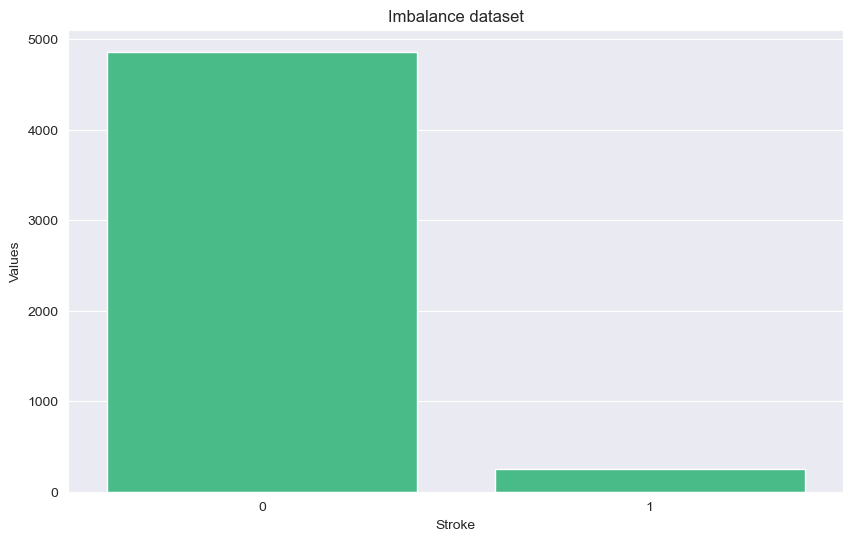

In [79]:
plt.figure(figsize=(10, 6))

values = df['stroke'].value_counts().reset_index()
bar_plot = sns.barplot(x=values['stroke'], y=values['count'])

# Adding labels and title
plt.xlabel('Stroke')
plt.ylabel('Values')
plt.title('Imbalance dataset')
plt.show

In [80]:
ros = SMOTEN(k_neighbors=5, sampling_strategy='minority', random_state=42)
X_train_upper, y_train_upper = ros.fit_resample(X_train, pd.DataFrame(y_train))

unique_values, counts = np.unique(y_train_upper, return_counts=True)
counts

array([4131, 4131], dtype=int64)

After over sampling we could see that the dataset its more overbalance, and we will see if with this we could see an improvement in the predictions

In [81]:
ros = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_train, y_train = ros.fit_resample(X_train, pd.DataFrame(y_train))

unique_values, counts = np.unique(y_train, return_counts=True)
counts

array([212, 212], dtype=int64)

We'll continue with the under-sampling technique as it demonstrated superior performance. This could be attributed to the predominance of categorical features and the limited amount of data, which restricts the degree of randomness we can introduce into the model.

In [82]:
# pass to 1D the array
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()
y_test = y_test.values.ravel()
y_train_upper = y_train_upper.values.ravel()
y_train_baseline = y_train_baseline.values.ravel()
y_validation_baseline = y_validation_baseline.values.ravel()
y_test_baseline = y_test_baseline.values.ravel()

# Baseline
To set a baseline prediction for our models, we'll use the mode, predicting the most frequent class. This will serve as our benchmark for comparing the performance of any future models.

As for the metric choice to evaluate model performance, we've selected **"Recall"**. This decision reflects our priority to detect all potential instances of stroke. By emphasizing recall, we aim to identify as many individuals at risk of stroke as possible, ensuring they receive necessary preparation and care if any issues arise.

0.6875


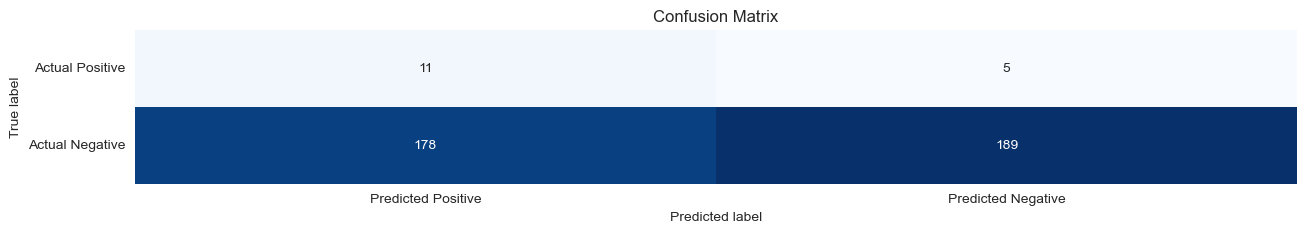

In [83]:
# baseline model
baseline_classifier = DummyClassifier(strategy="stratified")
baseline_classifier.fit(X_train, y_train)
baseline_predictions = baseline_classifier.predict(X_validation)
baseline_accuracy = recall_score(y_validation, baseline_predictions)

conf_matrix = confusion_matrix(y_validation, baseline_predictions, labels= [1,0])
print(baseline_accuracy)
conf_heatmap(conf_matrix)


As we could see the recall as a baseline, it's a very bad or existence way to predict so probable with a model we can increase the precision of the "Recall" with 06% of Assertiveness .

# Simple models 
We will bew writing simple models to have another benchmark without any adjustment or optimization

In [84]:
baseline_models(independent_x=X_train_baseline, 
                dependent_y=y_train_baseline, 
                independent_x_prediction=X_validation_baseline, 
                independent_y_prediction=y_validation_baseline)


LogisticRegression:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81       367
           1       0.09      0.69      0.16        16

    accuracy                           0.69       383
   macro avg       0.53      0.69      0.48       383
weighted avg       0.94      0.69      0.78       383

RidgeClassifier:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81       367
           1       0.09      0.69      0.16        16

    accuracy                           0.69       383
   macro avg       0.53      0.69      0.48       383
weighted avg       0.94      0.69      0.78       383

SGDClassifier:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84       367
           1       0.08      0.50      0.14        16

    accuracy                           0.73       383
   macro avg       0.52      0.62      0.49       383
weighted avg       

C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81       367
           1       0.09      0.69      0.16        16

    accuracy                           0.69       383
   macro avg       0.54      0.69      0.49       383
weighted avg       0.94      0.69      0.79       383

DecisionTreeClassifier:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       367
           1       0.12      0.19      0.15        16

    accuracy                           0.91       383
   macro avg       0.54      0.57      0.55       383
weighted avg       0.93      0.91      0.92       383



C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       367
           1       0.00      0.00      0.00        16

    accuracy                           0.96       383
   macro avg       0.48      0.50      0.49       383
weighted avg       0.92      0.96      0.94       383

ExtraTreesClassifier:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       367
           1       0.33      0.06      0.11        16

    accuracy                           0.96       383
   macro avg       0.65      0.53      0.54       383
weighted avg       0.93      0.96      0.94       383



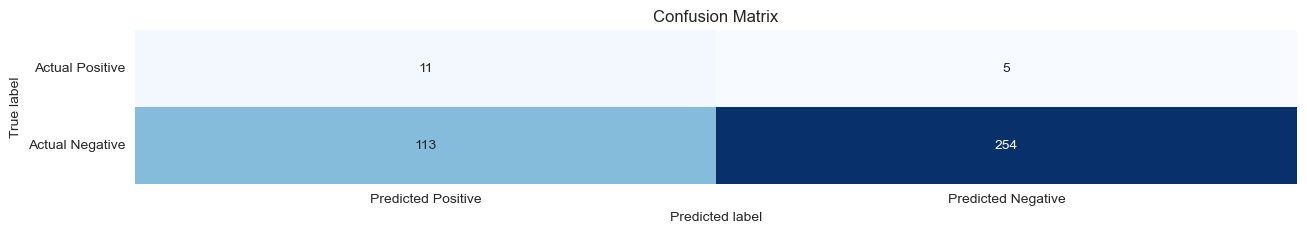

In [85]:
baseline_model = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train_baseline,y_train_baseline)

predictions_model= baseline_model.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)


In [86]:
train_report,validation_report =  classification_report_summary(baseline_model, X_train_baseline, y_train_baseline,X_validation,y_validation)
train_report

stroke    no stroke  accuracy    macro avg  weighted avg
precision    0.137767     0.987662  0.740502     0.562715      0.946175
recall       0.820755     0.736383  0.740502     0.778569      0.740502
f1-score     0.235932     0.843711  0.740502     0.539822      0.814043
support    212.000000  4131.000000  0.740502  4343.000000   4343.000000

0.7184945504087192


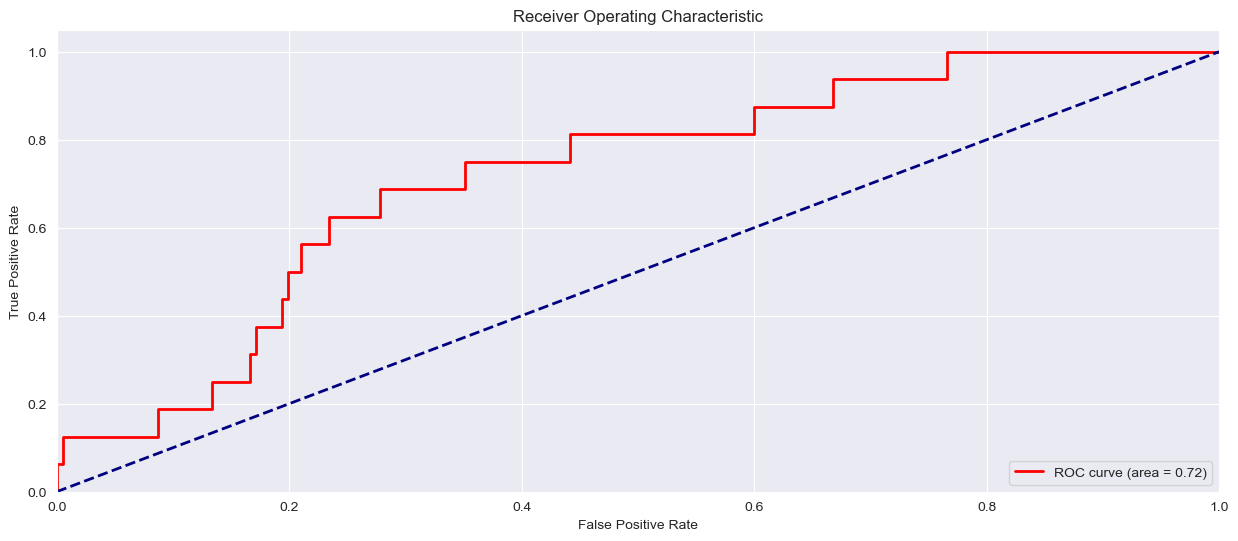

In [87]:
#  Get the predicted probabilities
y_pred_proba = baseline_model.predict_proba(X_validation)[:, 1]

#  Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba,  pos_label=1)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
baseline_model_metrics = {
    'Model_Name': "baseline_model",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
    }
print(roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

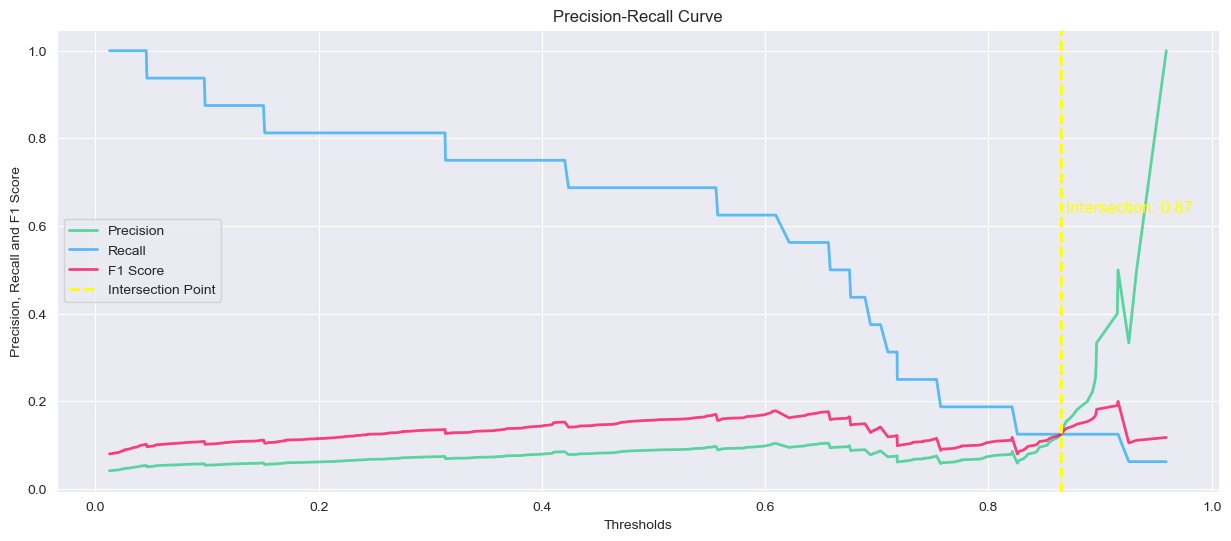

In [88]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [89]:
validation_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision   0.088710    0.980695  0.691906    0.534702      0.943432
recall      0.687500    0.692098  0.691906    0.689799      0.691906
f1-score    0.157143    0.811502  0.691906    0.484322      0.784165
support    16.000000  367.000000  0.691906  383.000000    383.000000

In [90]:
results_models = pd.DataFrame({
    'Model_Name': "baseline_model",
    'Model_parameters': "LogisticRegression(class_weight='balanced', random_state=42)",
    'roc_auc': roc_auc, 
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name' : "baseline_model_metrics"
}, index=range(1)) 

results_models.head()

Model_Name                                   Model_parameters  \
0  baseline_model  LogisticRegression(class_weight='balanced', ra...   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   

              metric_name  
0  baseline_model_metrics

# Modeling
once we had ready the pipeline, we will start exploring the different models to see which one performs the best for that we will apply this.

Fist we will be applying **grid search** to customize the **hyperparameters**, 

# Logistic regression
first we will be applying the simplest model using some hyperparameter tuning to optimize the best parameters and got the best results

In [91]:
hyper_parameter_tuning = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [5, 20,30,60,80,100, 200, 1000]
}

Apply the random search from the hyperparameter tuning and extract the model and the parameters that we need that has the best performance using this model

In [92]:
if re_run_model:
    random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=hyper_parameter_tuning, n_iter=100, cv=5, n_jobs=-1,random_state=42, scoring='recall')
    random_search.fit(X_train, y_train)
    joblib.dump(random_search, 'model_saved_vr2/logistic_regression_001.pkl')   
    
# Get the best model and evaluate on the test set
model_LR_001_load = joblib.load('model_saved_vr2/logistic_regression_001.pkl')
model_LR_001 = model_LR_001_load.best_estimator_
best_params = model_LR_001_load.best_params_
best_score = model_LR_001_load.best_score_

best_params

{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 100,
 'C': 0.0006951927961775605}

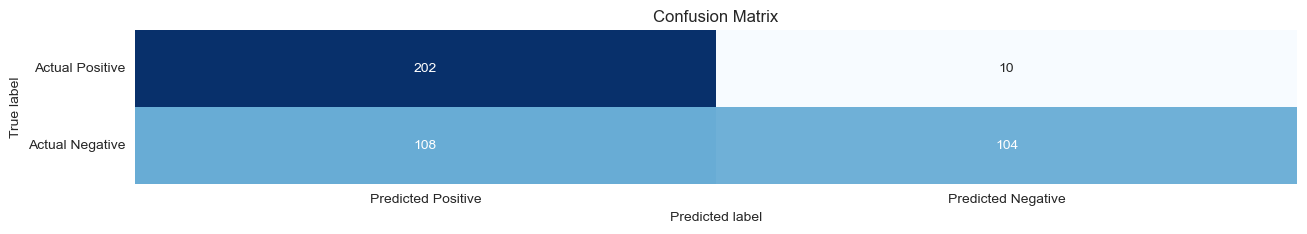

In [93]:
predictions_model= model_LR_001.predict(X_train)
conf_matrix = confusion_matrix(y_train, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)


In [94]:
predictions_model= model_LR_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])


After some hyperparameter tuning we could see the best values from the model, and also the recall its good for our predicted target

In [95]:
train_report,validation_report =  classification_report_summary(model_LR_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.651613    0.912281  0.721698    0.781947      0.781947
recall       0.952830    0.490566  0.721698    0.721698      0.721698
f1-score     0.773946    0.638037  0.721698    0.705992      0.705992
support    212.000000  212.000000  0.721698  424.000000    424.000000

0.7295640326975477


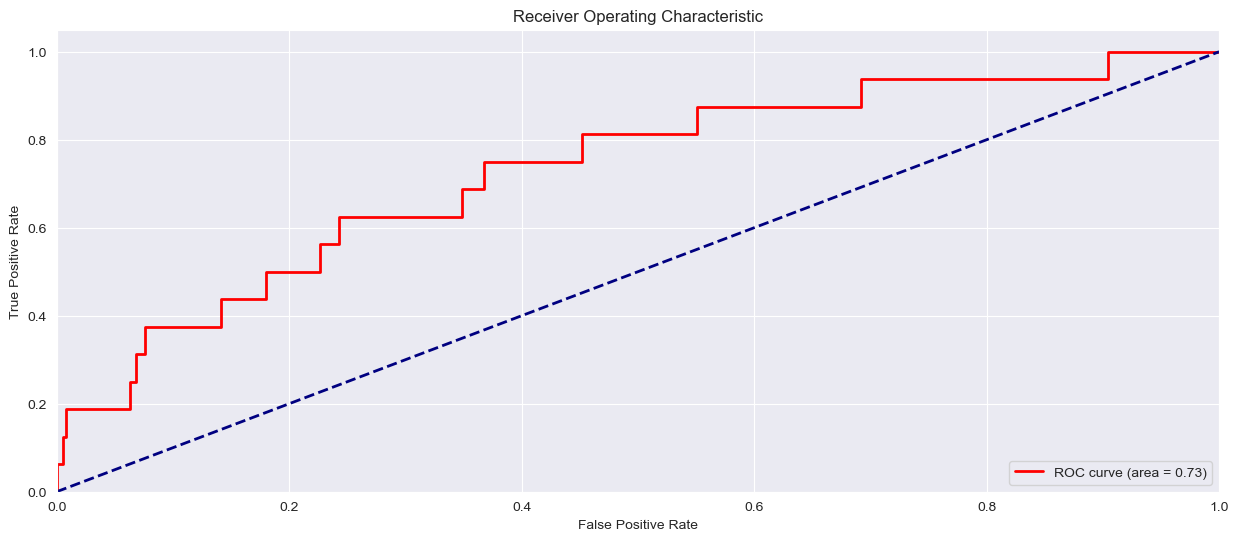

In [96]:
#  Get the predicted probabilities
y_pred_proba = model_LR_001.predict_proba(X_validation)[:, 1]

#  Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba,  pos_label=1)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_LR_001_metrics = {
    'Model_Name': "model_LR_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
    }
print(roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

We could see that our 1st model outperform the baseline model, so we will keep trying other models and see if we could get improvement in the performance

In [97]:
threshold_values_change(thresholds, y_pred_proba, y_validation)

thresholds  precision    recall  false_negative  true_negative  \
0       1.561550        0.0  0.000000             0.0            0.0   
1       0.561550        0.0  0.000000             0.0            0.0   
2       0.552445        0.0  0.000000             0.0            0.0   
3       0.551706        0.0  0.000000             0.0            0.0   
4       0.548865        0.0  0.000000             0.0            0.0   
...          ...        ...       ...             ...            ...   
1084    0.485997        1.0  0.041775           367.0           16.0   
1085    0.485619        1.0  0.041775           367.0           16.0   
1086    0.460266        1.0  0.041775           367.0           16.0   
1087    0.459743        1.0  0.041775           367.0           16.0   
1088    0.445494        1.0  0.041775           367.0           16.0   

      false_positive  true_positive  
0              367.0           16.0  
1              367.0           16.0  
2              367.0           16.0  
3              367.0           16.0  
4              367.0           16.0  
...              ...            ...  
1084             0.0            0.0  
1085             0.0            0.0  
1086             0.0            0.0  
1087             0.0            0.0  
1088             0.0            0.0  

[1089 rows x 7 columns]

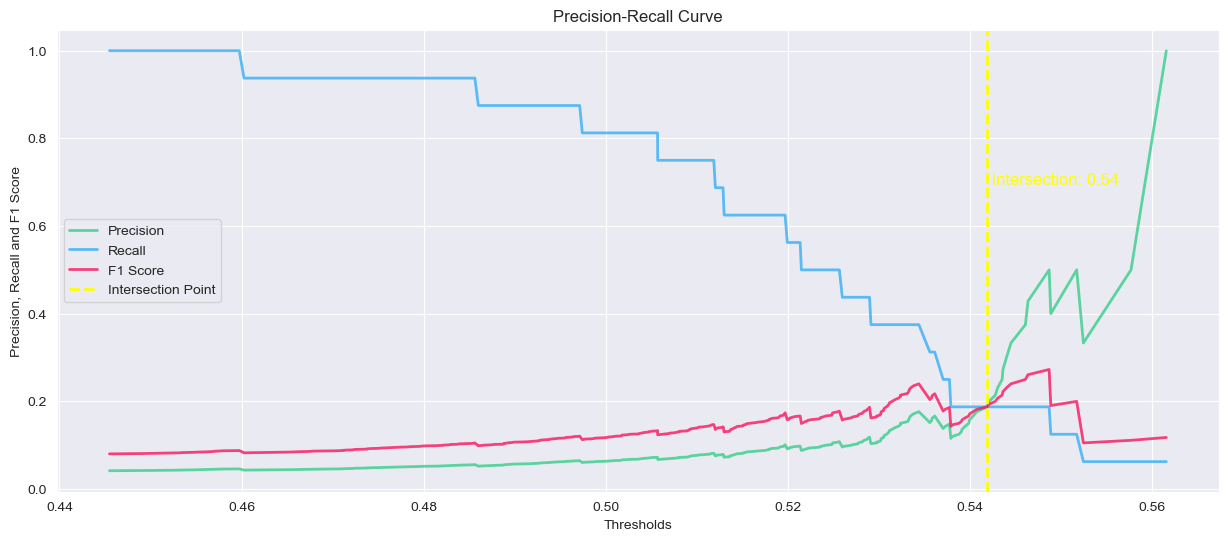

In [98]:
y_pred_proba = model_LR_001.predict_proba(X_validation)
thresholds_recall_curve(y_pred_proba[:, 1], y_validation) 

We could see  that the lower the threshold the best recall we had, but the idea its to fix the total quantity of values we had, so we need to validate this.

In [99]:
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row  = pd.DataFrame({
    'Model_Name': "model_LR_001",
    'Model_parameters': text,
    'roc_auc': roc_auc, 
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name' : "model_LR_001_metrics"
}, index=range(1)) 

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name                                   Model_parameters  \
0  baseline_model  LogisticRegression(class_weight='balanced', ra...   
1    model_LR_001  solver=liblinear, penalty=l2, max_iter=100, C=...   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   
1  0.729564      0.952830             0.8125        0.721698   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   
1             0.490862        0.773946             0.117647   

              metric_name  
0  baseline_model_metrics  
1    model_LR_001_metrics

After our 1st iteration using this model we could see a good performance, but we will try and explore other models to see if we could get an improvement.

# SVM

In [100]:
hyper_parameter_tuning = {
    'C': np.logspace(-3,3,20), 
    'kernel': ['linear', 'poly', 'rbf'],  
    'degree': np.arange(1,6),
}

In [101]:
# model setup for adding the probabilities
svm_classifier = svm.SVC(probability=True)
if re_run_model:
    random_search = RandomizedSearchCV(svm.SVC(), param_distributions=hyper_parameter_tuning, cv=5, n_jobs=-1,random_state=42, scoring='recall')
    random_search.fit(X_train, y_train)
    joblib.dump(random_search, 'model_saved_vr2/SVC_001.pkl')   
    
# Get the best model and evaluate on the test set
model_SVC_001_load = joblib.load('model_saved_vr2/SVC_001.pkl')
    
# Get the best model and evaluate on the test set
model_SVC_001 = model_SVC_001_load.best_estimator_
best_params = model_SVC_001_load.best_params_
best_score = model_SVC_001_load.best_score_
best_params

{'kernel': 'rbf', 'degree': 1, 'C': 1.438449888287663}

In [102]:
model_SVC_002 = svm.SVC(kernel='linear', degree=3, C=1000, probability=True)
model_SVC_002.fit(X_train, y_train)

SVC(C=1000, kernel='linear', probability=True)

The model's performance is commendable, especially when compared to logistic regression. However, given its complexity and the challenge of explaining it, we've decided not to include this model in the final result.

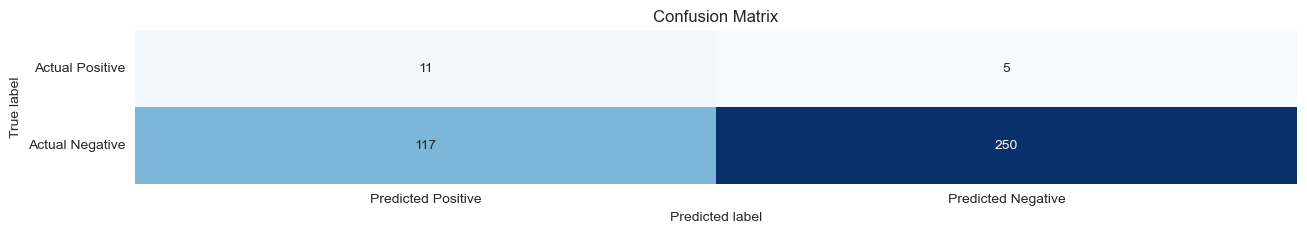

In [103]:
predictions_model= model_SVC_002.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model,labels= [1,0])
conf_heatmap(conf_matrix)

In [104]:
train_report,validation_report =  classification_report_summary(model_SVC_002, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.763948    0.821990  0.790094    0.792969      0.792969
recall       0.839623    0.740566  0.790094    0.790094      0.790094
f1-score     0.800000    0.779156  0.790094    0.789578      0.789578
support    212.000000  212.000000  0.790094  424.000000    424.000000

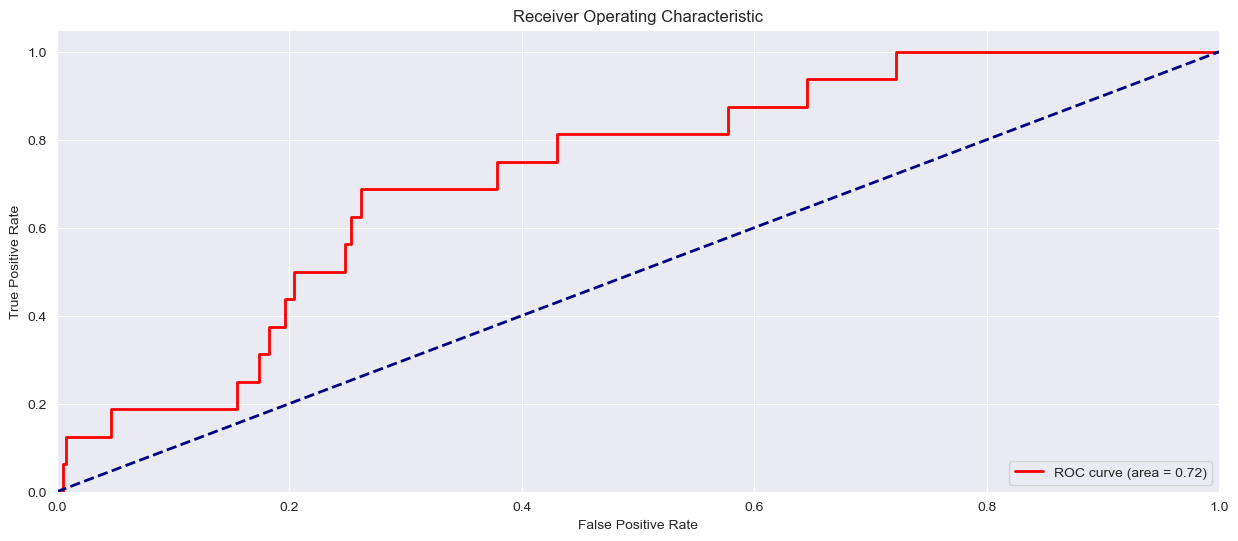

In [105]:
# Get the predicted probabilities
y_pred_proba = model_SVC_002.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds_002 = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_SVC_002_metrics = {
    'Model_Name': "model_SVC_002",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

#Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

We could see after the fitting that the model its predicting good enough,so this could be a good indication of the model performance for the training set, also the ROC curve its mostly covered the whole space indicating that this model had a good relationship with the predicted values.

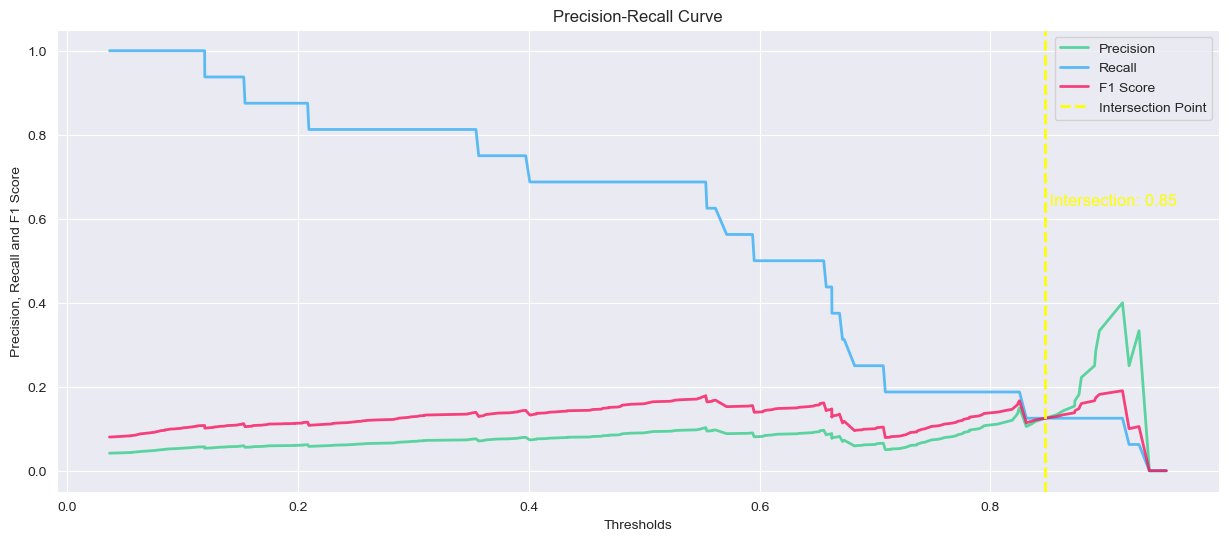

In [106]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [107]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row  = pd.DataFrame({
    'Model_Name': "model_SVC_002",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name' : "model_SVC_002_metrics"
}, index=range(1)) 

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name                                   Model_parameters  \
0  baseline_model  LogisticRegression(class_weight='balanced', ra...   
1    model_LR_001  solver=liblinear, penalty=l2, max_iter=100, C=...   
2   model_SVC_002          kernel=rbf, degree=1, C=1.438449888287663   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   
1  0.729564      0.952830             0.8125        0.721698   
2  0.719346      0.839623             0.6875        0.790094   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   
1             0.490862        0.773946             0.117647   
2             0.681462        0.800000             0.152778   

              metric_name  
0  baseline_model_metrics  
1    model_LR_001_metrics  
2   model_SVC_002_metrics

Ultimately, we didn't observe any improvement by incorporating these models.


# K-Nearest Neighbors Classifier

In [108]:
hyper_parameter_tuning =  {
    'n_neighbors': [3, 6,7,8],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [109]:
if re_run_model:
    GridSearch = GridSearchCV(KNeighborsClassifier(), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/KNN_001.pkl')   
    
# Get the best model and evaluate on the test set
model_KNN_001_load = joblib.load('model_saved_vr2/KNN_001.pkl')
    
# Get the best model and evaluate on the test set
model_KNN_001 = model_KNN_001_load.best_estimator_
best_params = model_KNN_001_load.best_params_
best_score = model_KNN_001_load.best_score_
best_params

{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_neighbors': 7,
 'weights': 'distance'}

In [110]:
model_KNN_001 = KNeighborsClassifier(algorithm= 'ball_tree',
                                     metric= 'manhattan',
                                     n_neighbors= 7,
                                     weights= 'uniform')

model_KNN_001.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=7)

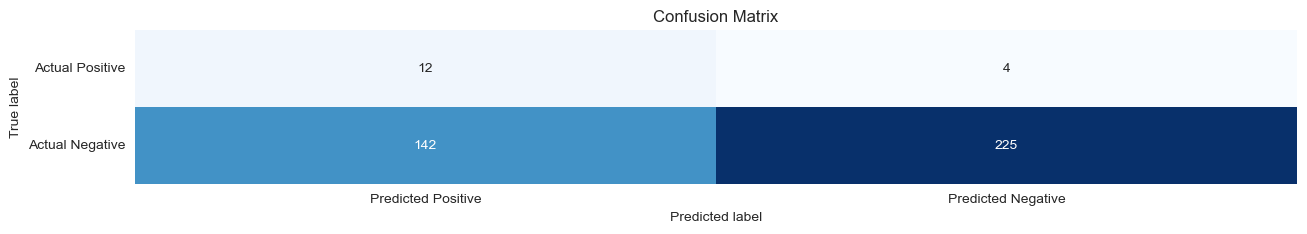

In [111]:
predictions_model= model_KNN_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [112]:
train_report,validation_report =  classification_report_summary(model_KNN_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.766816    0.796020   0.78066    0.781418      0.781418
recall       0.806604    0.754717   0.78066    0.780660      0.780660
f1-score     0.786207    0.774818   0.78066    0.780513      0.780513
support    212.000000  212.000000   0.78066  424.000000    424.000000

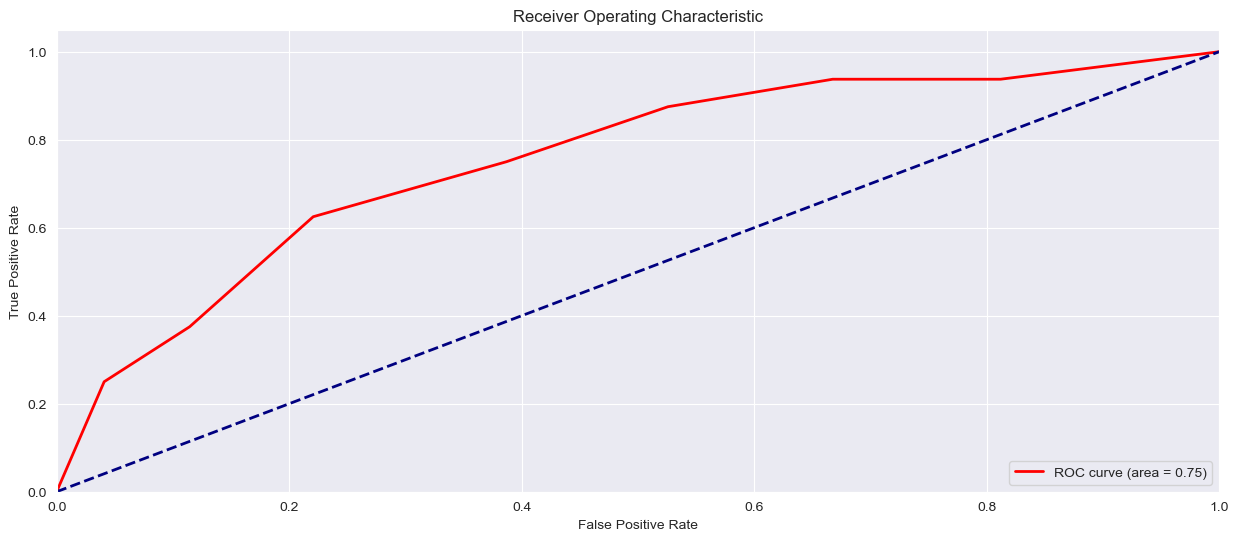

In [113]:
# Get the predicted probabilities
y_pred_proba = model_KNN_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)


# table for a dataset, for comparing models
model_KNN_001_metrics = {
    'Model_Name': "model_KNN_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

# Plot the ROC curve
#Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

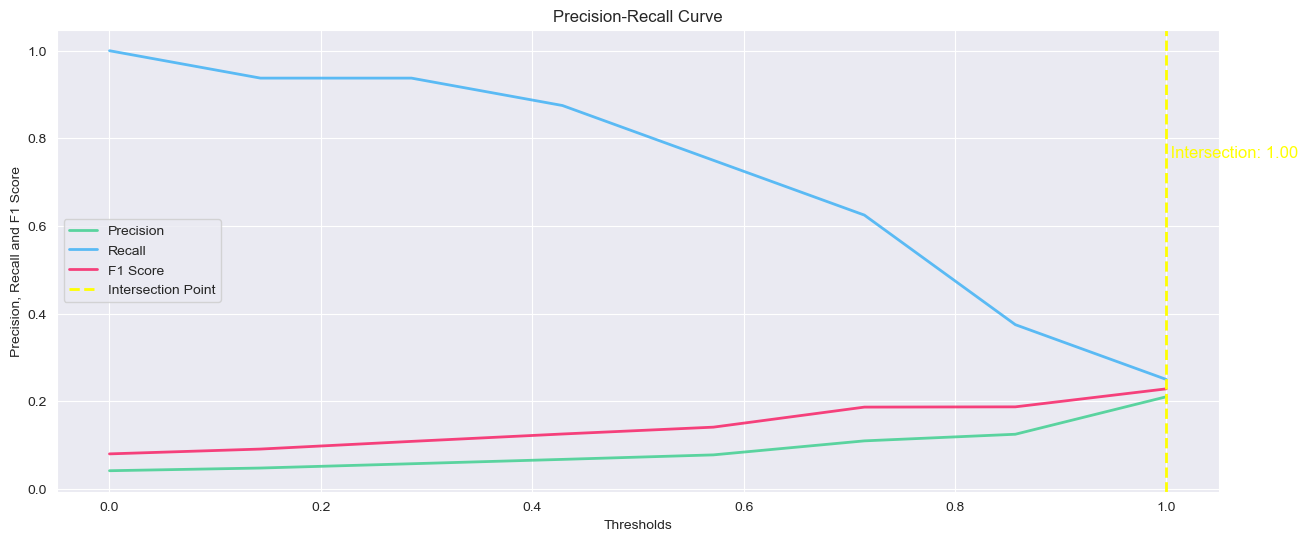

In [114]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [115]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row  = pd.DataFrame({
    'Model_Name': "model_KNN_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name' : "model_KNN_001_metrics"
}, index=range(1)) 

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name                                   Model_parameters  \
0  baseline_model  LogisticRegression(class_weight='balanced', ra...   
1    model_LR_001  solver=liblinear, penalty=l2, max_iter=100, C=...   
2   model_SVC_002          kernel=rbf, degree=1, C=1.438449888287663   
3   model_KNN_001  algorithm=ball_tree, metric=euclidean, n_neigh...   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   
1  0.729564      0.952830             0.8125        0.721698   
2  0.719346      0.839623             0.6875        0.790094   
3  0.754343      0.806604             0.7500        0.780660   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   
1             0.490862        0.773946             0.117647   
2             0.681462        0.800000             0.152778   
3             0.618799        0.786207             0.141176   

              metric_name  
0  baseline_model_metrics  
1    model_LR_001_metrics  
2   model_SVC_002_metrics  
3   model_KNN_001_metrics

We observed an improvement in model performance when using KNN on the validation set. This is likely because KNN relies on distance metrics that effectively utilize the distribution of multiple values, leading to better generalization and enhanced model performance.

# Random Forest Classifier


In [116]:
hyper_parameter_tuning = {
    'n_estimators': [15, 20,25,30, 40, 100],            
    'max_depth': [25,30,50,200],           
    'min_samples_split': [2, 5],           
    'min_samples_leaf': [1, 2],             
    'max_features': ['sqrt', 'log2'],   
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.2, 0.3, 0.4]
}

In [117]:
if re_run_model:
    GridSearch = GridSearchCV(RandomForestClassifier(random_state=100), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train_upper, y_train_upper)
    joblib.dump(GridSearch, 'model_saved_vr2/RandomForest_001.pkl')   

# Get the best model and evaluate on the test set
model_RandomForest_001_load = joblib.load('model_saved_vr2/RandomForest_001.pkl')

# Get the best model and evaluate on the test set
model_RandomForest_001 = model_RandomForest_001_load.best_estimator_
best_params = model_RandomForest_001_load.best_params_
best_score = model_RandomForest_001_load.best_score_
best_params

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}

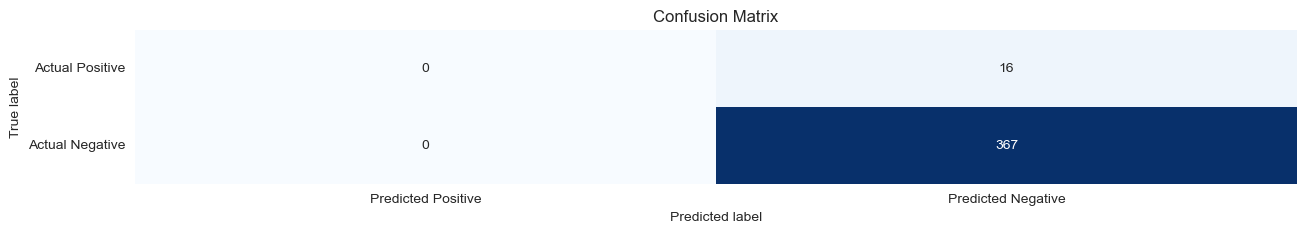

In [118]:
predictions_model= model_RandomForest_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [119]:
train_report,validation_report =  classification_report_summary(model_RandomForest_001, X_train, y_train,X_validation,y_validation)
train_report

C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\metr

stroke   no stroke  accuracy   macro avg  weighted avg
precision     0.0    0.500000       0.5    0.250000      0.250000
recall        0.0    1.000000       0.5    0.500000      0.500000
f1-score      0.0    0.666667       0.5    0.333333      0.333333
support     212.0  212.000000       0.5  424.000000    424.000000

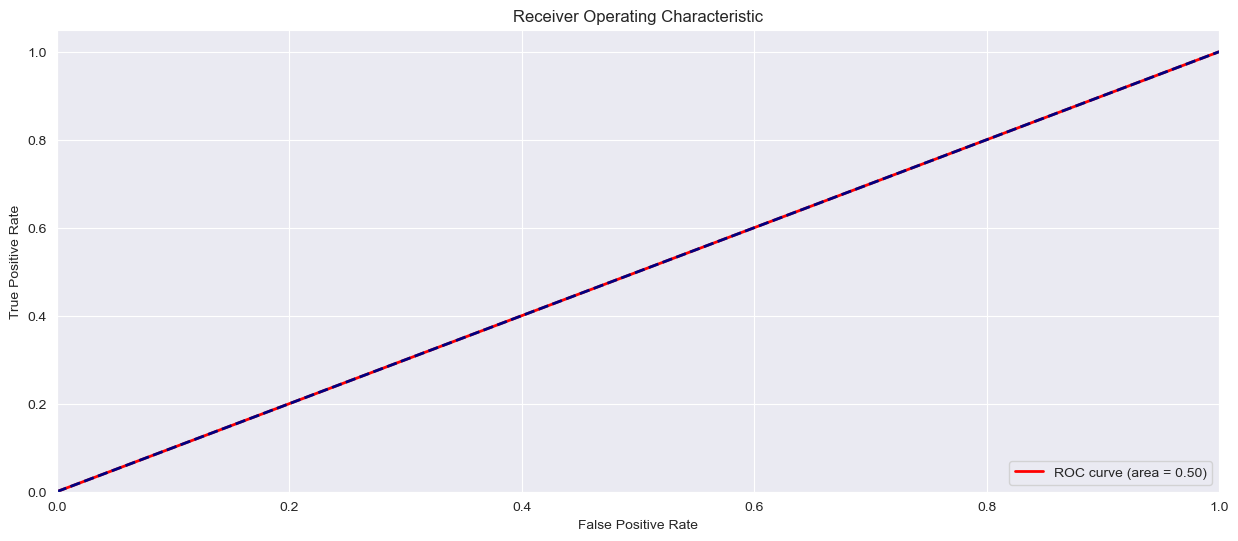

In [120]:
# Get the predicted probabilities
y_pred_proba = model_RandomForest_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)


# table for a dataset, for comparing models
model_RandomForest_001_metrics = {
    'Model_Name': "model_RandomForest_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

# Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

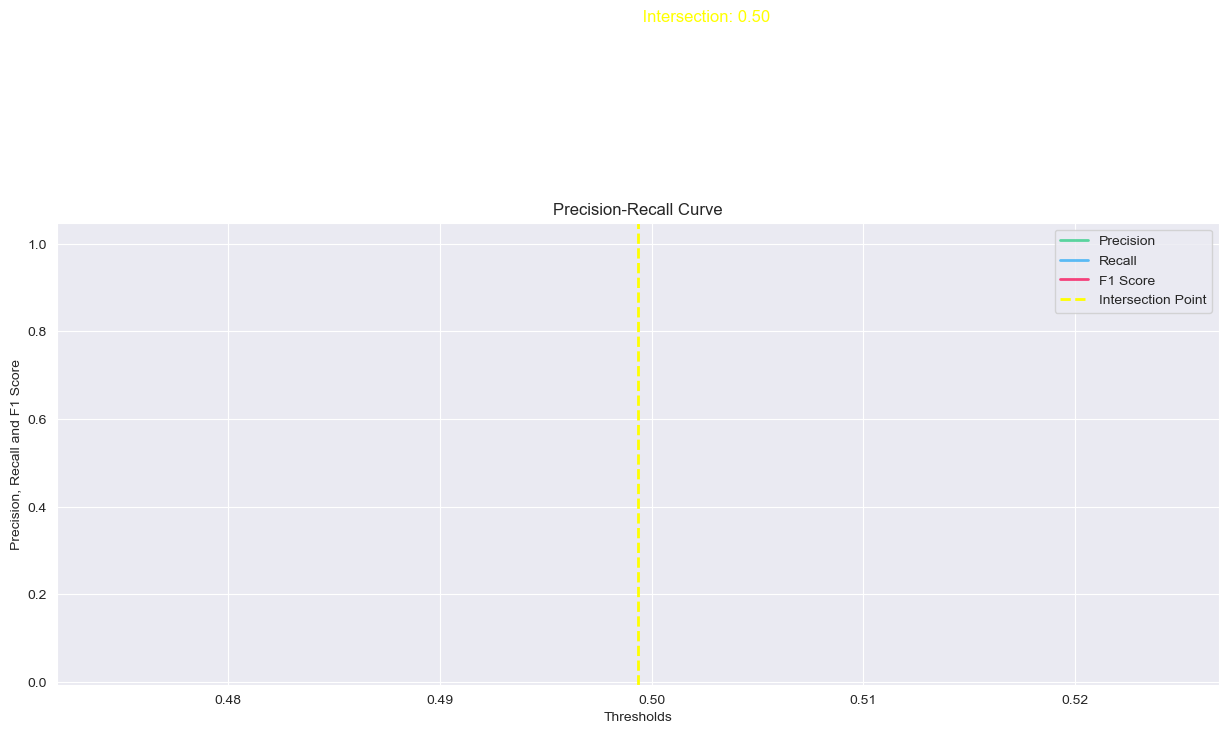

In [121]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [122]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row  = pd.DataFrame({
    'Model_Name': "model_RandomForest_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name' : "model_RandomForest_001_metrics"
}, index=range(1)) 

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name                                   Model_parameters  \
0          baseline_model  LogisticRegression(class_weight='balanced', ra...   
1            model_LR_001  solver=liblinear, penalty=l2, max_iter=100, C=...   
2           model_SVC_002          kernel=rbf, degree=1, C=1.438449888287663   
3           model_KNN_001  algorithm=ball_tree, metric=euclidean, n_neigh...   
4  model_RandomForest_001  criterion=gini, max_depth=25, max_features=sqr...   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   
1  0.729564      0.952830             0.8125        0.721698   
2  0.719346      0.839623             0.6875        0.790094   
3  0.754343      0.806604             0.7500        0.780660   
4  0.500000      0.000000             0.0000        0.500000   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   
1             0.490862        0.773946             0.117647   
2             0.681462        0.800000             0.152778   
3             0.618799        0.786207             0.141176   
4             0.958225        0.000000             0.000000   

                      metric_name  
0          baseline_model_metrics  
1            model_LR_001_metrics  
2           model_SVC_002_metrics  
3           model_KNN_001_metrics  
4  model_RandomForest_001_metrics

The "model_RandomForest_001" is not performing well, possibly because the sample size is too small, preventing the trees from adequately learning the underlying patterns in the dataset.
we could not predict a single value

Seems that had a perfect prediction, but the model its giving me an error when trying to predict because its predicting all the positive values correctly
Probably we will be skipping this model

# Naive Bayes 

In [123]:
hyper_parameter_tuning = {
    'var_smoothing': np.logspace(-9, 0, 20)
}

In [124]:
if re_run_model:
    random_search = RandomizedSearchCV(GaussianNB(), param_distributions=hyper_parameter_tuning, n_iter=20, cv=5, n_jobs=-1,random_state=42, scoring='recall')
    random_search.fit(X_train, y_train)
    joblib.dump(random_search, 'model_saved_vr2/GNB_001.pkl')   
    
# Get the best model and evaluate on the test set
GNB_001_load = joblib.load('model_saved_vr2/GNB_001.pkl')
GNB_001 = GNB_001_load.best_estimator_
best_params = GNB_001_load.best_params_
best_score = GNB_001_load.best_score_
best_params

{'var_smoothing': 1e-09}

In [125]:
conf_matrix

array([[  0,  16],
       [  0, 367]], dtype=int64)

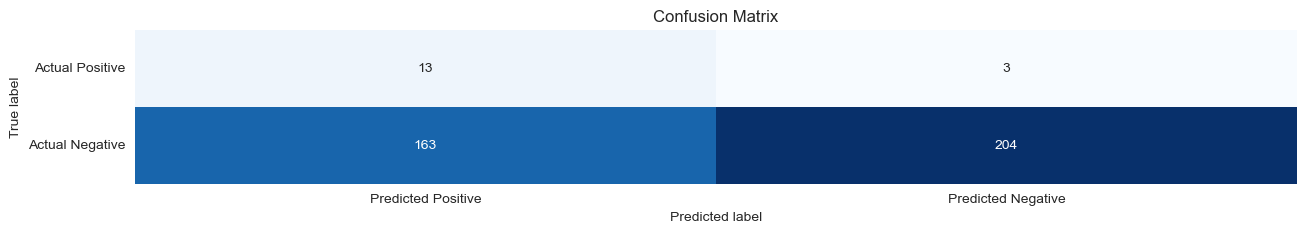

In [126]:
predictions_model= GNB_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [127]:
train_report,validation_report =  classification_report_summary(GNB_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.666667    0.810811  0.716981    0.738739      0.738739
recall       0.867925    0.566038  0.716981    0.716981      0.716981
f1-score     0.754098    0.666667  0.716981    0.710383      0.710383
support    212.000000  212.000000  0.716981  424.000000    424.000000

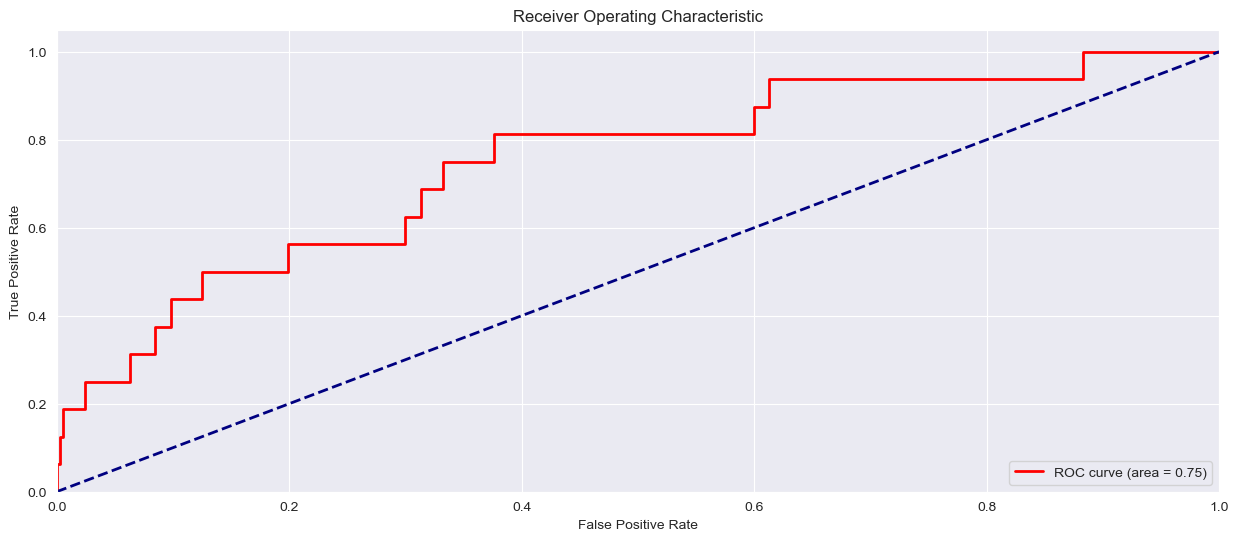

In [128]:
# Get the predicted probabilities
y_pred_proba = GNB_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_GNB_001_metrics = {
    'Model_Name': "GNB_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

# Step 5: Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

In [129]:
threshold_values_change(thresholds, y_pred_proba, y_validation)

thresholds  precision    recall  false_negative  true_negative  \
0     2.000000e+00        0.0  0.000000             0.0            0.0   
1     9.999999e-01        0.0  0.000000             0.0            0.0   
2     9.999994e-01        0.0  0.000000             0.0            0.0   
3     9.999994e-01        0.0  0.000000             0.0            0.0   
4     9.999989e-01        0.0  0.000000             0.0            0.0   
...            ...        ...       ...             ...            ...   
1084  4.337727e-02        1.0  0.041775           367.0           16.0   
1085  4.334284e-02        1.0  0.041775           367.0           16.0   
1086  1.400386e-50        1.0  0.041775           367.0           16.0   
1087  1.209679e-50        1.0  0.041775           367.0           16.0   
1088  2.339591e-53        1.0  0.041775           367.0           16.0   

      false_positive  true_positive  
0              367.0           16.0  
1              367.0           16.0  
2              367.0           16.0  
3              367.0           16.0  
4              367.0           16.0  
...              ...            ...  
1084             0.0            0.0  
1085             0.0            0.0  
1086             0.0            0.0  
1087             0.0            0.0  
1088             0.0            0.0  

[1089 rows x 7 columns]

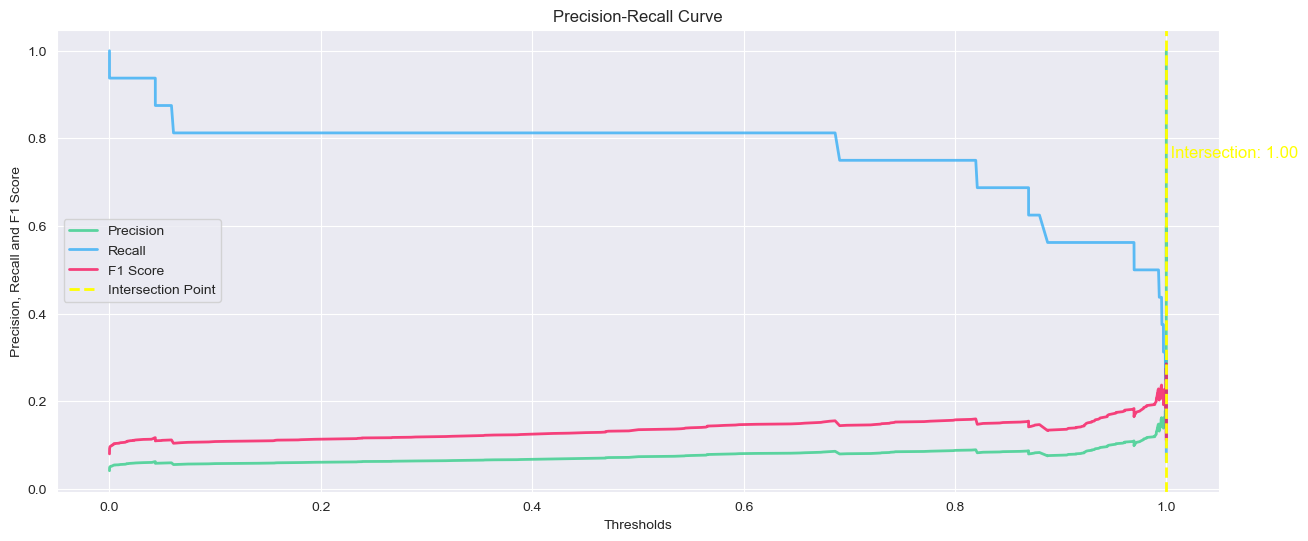

In [130]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [131]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row = pd.DataFrame({
    'Model_Name': "GNB_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name': "model_GNB_001_metrics"
}, index=range(1))

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name                                   Model_parameters  \
0          baseline_model  LogisticRegression(class_weight='balanced', ra...   
1            model_LR_001  solver=liblinear, penalty=l2, max_iter=100, C=...   
2           model_SVC_002          kernel=rbf, degree=1, C=1.438449888287663   
3           model_KNN_001  algorithm=ball_tree, metric=euclidean, n_neigh...   
4  model_RandomForest_001  criterion=gini, max_depth=25, max_features=sqr...   
5                 GNB_001                                var_smoothing=1e-09   

    roc_auc  Recall_train  Recall_validation  accuracy_train  \
0  0.718495      0.820755             0.6875        0.740502   
1  0.729564      0.952830             0.8125        0.721698   
2  0.719346      0.839623             0.6875        0.790094   
3  0.754343      0.806604             0.7500        0.780660   
4  0.500000      0.000000             0.0000        0.500000   
5  0.748808      0.867925             0.8125        0.716981   

   accuracy_validation  f1_score_train  f1_score_validation  \
0             0.691906        0.235932             0.157143   
1             0.490862        0.773946             0.117647   
2             0.681462        0.800000             0.152778   
3             0.618799        0.786207             0.141176   
4             0.958225        0.000000             0.000000   
5             0.566580        0.754098             0.135417   

                      metric_name  
0          baseline_model_metrics  
1            model_LR_001_metrics  
2           model_SVC_002_metrics  
3           model_KNN_001_metrics  
4  model_RandomForest_001_metrics  
5           model_GNB_001_metrics

This model is performing quite well; it shows promising results. Therefore, we've decided to include it in the pool of models to further explore its potential for improving overall performance.

# Gradient Boosting Classifier

In [132]:
hyper_parameter_tuning = {
    'n_estimators': [25, 50, 100],                 # Number of trees in the forest
    'learning_rate': [0.001,0.005, 0.01],              # Learning rate (shrinkage)
    'max_depth': [4, 5, 6],                         # Maximum depth of the tree
    'min_samples_split': [2,4],                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4],     
    'max_features': ['sqrt', 'log2'],
}

In [133]:
# We try to apply the upper sampling dataset, but the performance was around 15% for recall, so predict too much wrong cases.
if re_run_model:
    GridSearch = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train_upper, y_train_upper)
    joblib.dump(GridSearch, 'model_saved_vr2/GradientBoosting_001.pkl')   

# work fine with the dataset where we reduce the dependent variable
if re_run_model:
    GridSearch = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/GradientBoosting_002.pkl')   

# Get the best model and evaluate on the test set
model_GradientBoosting_001_load = joblib.load('model_saved_vr2/GradientBoosting_002.pkl')
    
# Get the best model and evaluate on the test set
model_GradientBoosting_001 = model_GradientBoosting_001_load.best_estimator_
best_params = model_GradientBoosting_001_load.best_params_
best_score = model_GradientBoosting_001_load.best_score_
best_params

{'learning_rate': 0.001,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

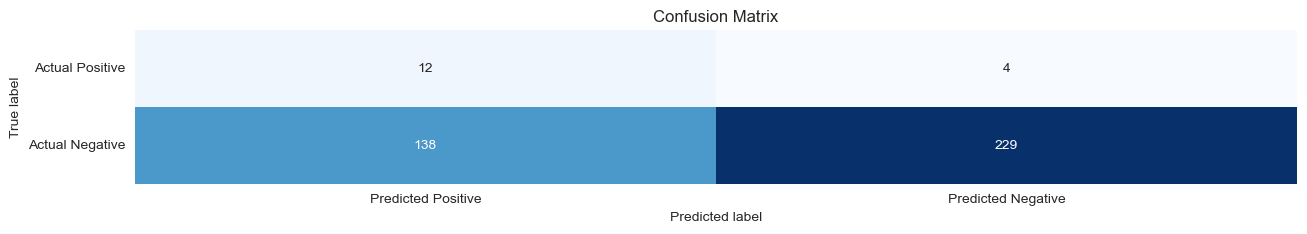

In [134]:
predictions_model= model_GradientBoosting_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

For a special reason when we use the reduce dataset the performance improve and got closer to 90%, so it's a good behavior

In [135]:
train_report,validation_report =  classification_report_summary(model_GradientBoosting_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.748062    0.885542  0.801887    0.816802      0.816802
recall       0.910377    0.693396  0.801887    0.801887      0.801887
f1-score     0.821277    0.777778  0.801887    0.799527      0.799527
support    212.000000  212.000000  0.801887  424.000000    424.000000

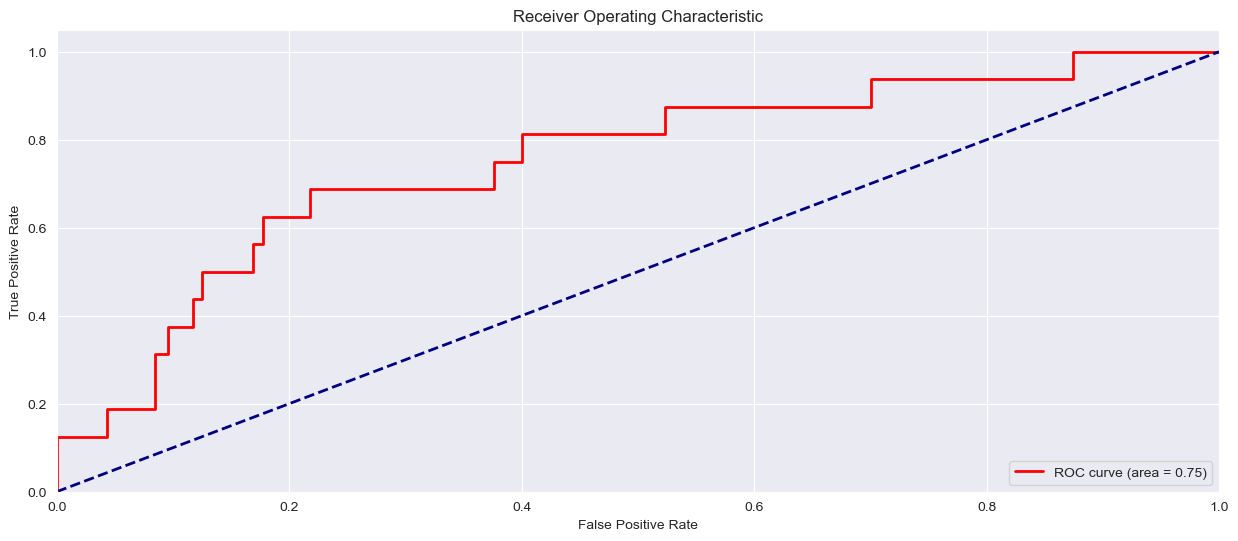

In [136]:
# Get the predicted probabilities
y_pred_proba = model_GradientBoosting_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_GradientBoosting_001_metrics = {
    'Model_Name': "model_GradientBoosting_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

In [137]:
threshold_values_change(thresholds, y_pred_proba, y_validation)


thresholds  precision    recall  false_negative  true_negative  \
0       1.515411        0.0  0.000000             0.0            0.0   
1       0.515411        0.0  0.000000             0.0            0.0   
2       0.514715        0.0  0.000000             0.0            0.0   
3       0.511596        0.0  0.000000             0.0            0.0   
4       0.511507        0.0  0.000000             0.0            0.0   
...          ...        ...       ...             ...            ...   
2020    0.477083        1.0  0.041775           367.0           16.0   
2021    0.477039        1.0  0.041775           367.0           16.0   
2022    0.476988        1.0  0.041775           367.0           16.0   
2023    0.476944        1.0  0.041775           367.0           16.0   
2024    0.476702        1.0  0.041775           367.0           16.0   

      false_positive  true_positive  
0              367.0           16.0  
1              367.0           16.0  
2              367.0           16.0  
3              367.0           16.0  
4              367.0           16.0  
...              ...            ...  
2020             0.0            0.0  
2021             0.0            0.0  
2022             0.0            0.0  
2023             0.0            0.0  
2024             0.0            0.0  

[2025 rows x 7 columns]

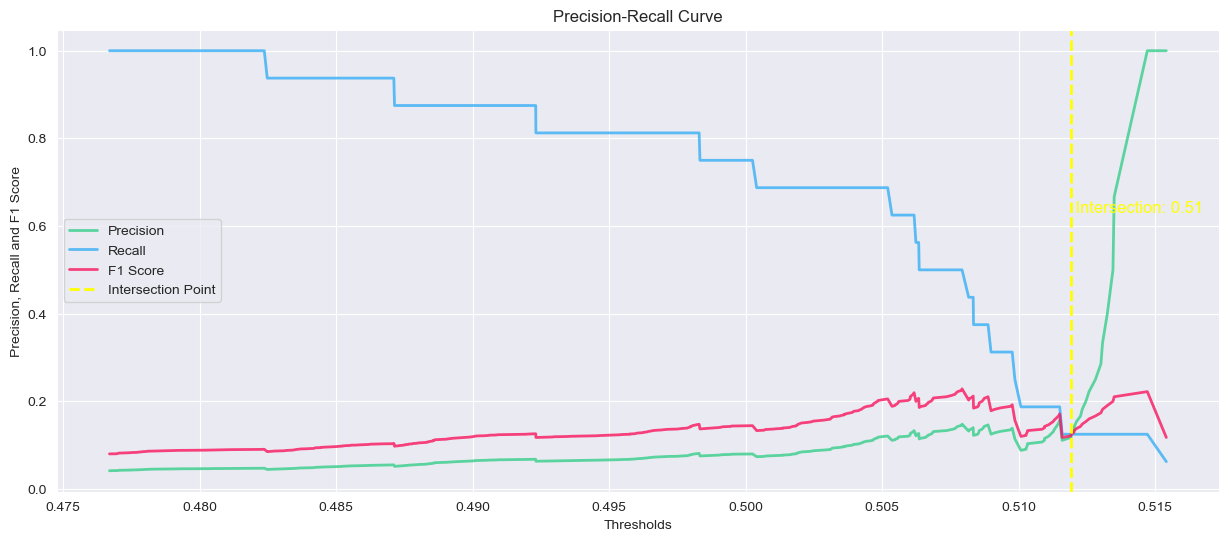

In [138]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [139]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row = pd.DataFrame({
    'Model_Name': "model_GradientBoosting_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name': "model_GradientBoosting_001_metrics"
}, index=range(1))

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name  \
0              baseline_model   
1                model_LR_001   
2               model_SVC_002   
3               model_KNN_001   
4      model_RandomForest_001   
5                     GNB_001   
6  model_GradientBoosting_001   

                                    Model_parameters   roc_auc  Recall_train  \
0  LogisticRegression(class_weight='balanced', ra...  0.718495      0.820755   
1  solver=liblinear, penalty=l2, max_iter=100, C=...  0.729564      0.952830   
2          kernel=rbf, degree=1, C=1.438449888287663  0.719346      0.839623   
3  algorithm=ball_tree, metric=euclidean, n_neigh...  0.754343      0.806604   
4  criterion=gini, max_depth=25, max_features=sqr...  0.500000      0.000000   
5                                var_smoothing=1e-09  0.748808      0.867925   
6  learning_rate=0.001, max_depth=4, max_features...  0.750681      0.910377   

   Recall_validation  accuracy_train  accuracy_validation  f1_score_train  \
0             0.6875        0.740502             0.691906        0.235932   
1             0.8125        0.721698             0.490862        0.773946   
2             0.6875        0.790094             0.681462        0.800000   
3             0.7500        0.780660             0.618799        0.786207   
4             0.0000        0.500000             0.958225        0.000000   
5             0.8125        0.716981             0.566580        0.754098   
6             0.7500        0.801887             0.629243        0.821277   

   f1_score_validation                         metric_name  
0             0.157143              baseline_model_metrics  
1             0.117647                model_LR_001_metrics  
2             0.152778               model_SVC_002_metrics  
3             0.141176               model_KNN_001_metrics  
4             0.000000      model_RandomForest_001_metrics  
5             0.135417               model_GNB_001_metrics  
6             0.144578  model_GradientBoosting_001_metrics

We observed promising results with the training dataset, especially since we utilized the downscaled target variable dataset. This approach has notably enhanced the model's performance and efficacy.

# AdaBoost Classifier

In [140]:
hyper_parameter_tuning = {
    'n_estimators': [2,5,10,50, 100, 200],                 # Number of weak learners (base estimators)
    'learning_rate': [0.00001,0.0001,0.001, 0.005, 0.1, 1.0],    # Learning rate
}


In [141]:
if re_run_model:
    GridSearch = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/AdaBoostClassifier_001.pkl')   

# we could not see any improvement using the logistic regression inside an adda boost
if re_run_model:
    LG_002 = LogisticRegression(solver='liblinear', penalty='l2', max_iter=100, C=0.0006951927961775605)
    GridSearch = GridSearchCV(AdaBoostClassifier(random_state=42,estimator=LG_002), param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/AdaBoostClassifier_LR_002.pkl')   

# Get the best model and evaluate on the test set
AdaBoostClassifier_001_load = joblib.load('model_saved_vr2/AdaBoostClassifier_001.pkl')
    
# Get the best model and evaluate on the test set
AdaBoostClassifier_001 = AdaBoostClassifier_001_load.best_estimator_
best_params = AdaBoostClassifier_001_load.best_params_
best_score = AdaBoostClassifier_001_load.best_score_
best_params

{'learning_rate': 1e-05, 'n_estimators': 2}

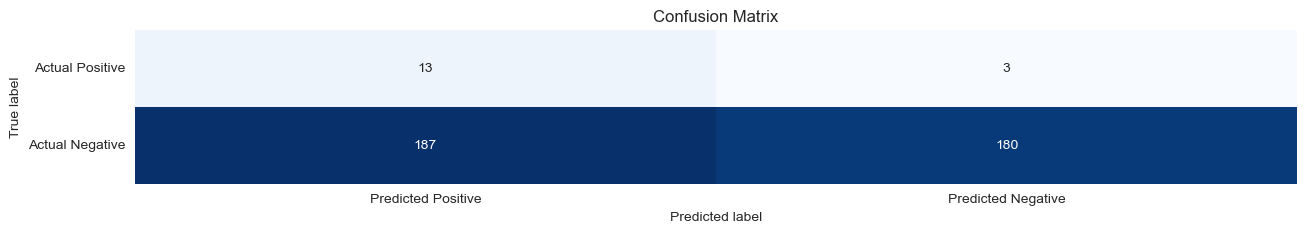

In [142]:
predictions_model= AdaBoostClassifier_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [143]:
train_report,validation_report =  classification_report_summary(AdaBoostClassifier_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.672131    0.941176  0.747642    0.806654      0.806654
recall       0.966981    0.528302  0.747642    0.747642      0.747642
f1-score     0.793037    0.676737  0.747642    0.734887      0.734887
support    212.000000  212.000000  0.747642  424.000000    424.000000

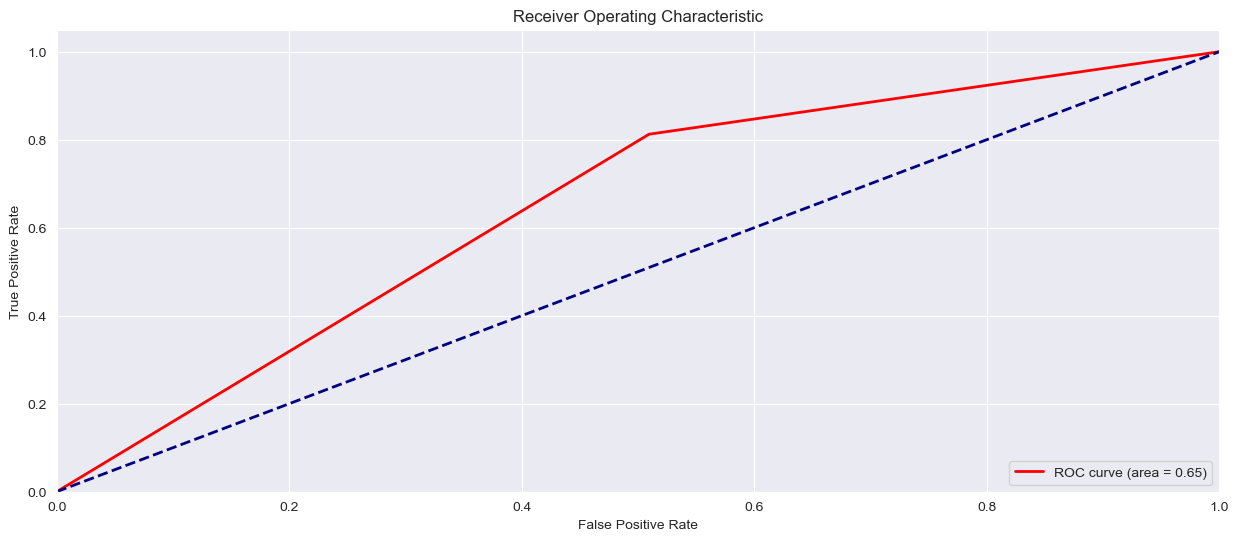

In [144]:
# Get the predicted probabilities
y_pred_proba = AdaBoostClassifier_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_AdaBoostClassifier_001_metrics = {
    'Model_Name': "AdaBoostClassifier_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

In [145]:
threshold_values_change(thresholds, y_pred_proba, y_validation)

thresholds  precision    recall  false_negative  true_negative  \
0    1.672130     0.0000  0.000000             0.0            0.0   
1    0.672130     0.0000  0.000000             0.0            0.0   
2    0.058824     0.0000  0.000000             0.0            0.0   
3    1.672130     0.8125  0.065000           187.0           13.0   
4    0.672130     0.8125  0.065000           187.0           13.0   
5    0.058824     0.8125  0.065000           187.0           13.0   
6    1.672130     1.0000  0.041775           367.0           16.0   
7    0.672130     1.0000  0.041775           367.0           16.0   
8    0.058824     1.0000  0.041775           367.0           16.0   

   false_positive  true_positive  
0           367.0           16.0  
1           367.0           16.0  
2           367.0           16.0  
3           180.0            3.0  
4           180.0            3.0  
5           180.0            3.0  
6             0.0            0.0  
7             0.0            0.0  
8             0.0            0.0

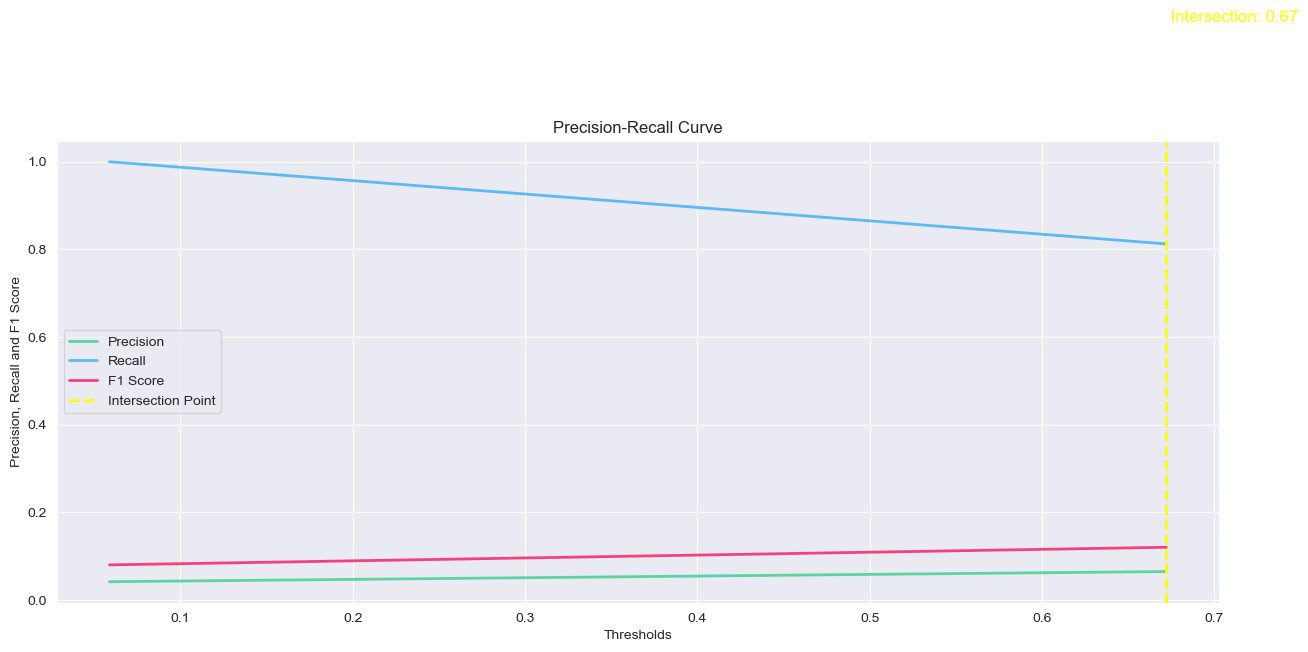

In [146]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [147]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row = pd.DataFrame({
    'Model_Name': "AdaBoostClassifier_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name': "model_AdaBoostClassifier_001_metrics"
}, index=range(1))

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name  \
0              baseline_model   
1                model_LR_001   
2               model_SVC_002   
3               model_KNN_001   
4      model_RandomForest_001   
5                     GNB_001   
6  model_GradientBoosting_001   
7      AdaBoostClassifier_001   

                                    Model_parameters   roc_auc  Recall_train  \
0  LogisticRegression(class_weight='balanced', ra...  0.718495      0.820755   
1  solver=liblinear, penalty=l2, max_iter=100, C=...  0.729564      0.952830   
2          kernel=rbf, degree=1, C=1.438449888287663  0.719346      0.839623   
3  algorithm=ball_tree, metric=euclidean, n_neigh...  0.754343      0.806604   
4  criterion=gini, max_depth=25, max_features=sqr...  0.500000      0.000000   
5                                var_smoothing=1e-09  0.748808      0.867925   
6  learning_rate=0.001, max_depth=4, max_features...  0.750681      0.910377   
7                learning_rate=1e-05, n_estimators=2  0.651482      0.966981   

   Recall_validation  accuracy_train  accuracy_validation  f1_score_train  \
0             0.6875        0.740502             0.691906        0.235932   
1             0.8125        0.721698             0.490862        0.773946   
2             0.6875        0.790094             0.681462        0.800000   
3             0.7500        0.780660             0.618799        0.786207   
4             0.0000        0.500000             0.958225        0.000000   
5             0.8125        0.716981             0.566580        0.754098   
6             0.7500        0.801887             0.629243        0.821277   
7             0.8125        0.747642             0.503916        0.793037   

   f1_score_validation                           metric_name  
0             0.157143                baseline_model_metrics  
1             0.117647                  model_LR_001_metrics  
2             0.152778                 model_SVC_002_metrics  
3             0.141176                 model_KNN_001_metrics  
4             0.000000        model_RandomForest_001_metrics  
5             0.135417                 model_GNB_001_metrics  
6             0.144578    model_GradientBoosting_001_metrics  
7             0.120370  model_AdaBoostClassifier_001_metrics

So far, the best performing model appears to be the one we initially created. Therefore, it seems we will need to conduct further analysis to refine it.





# XGBoost Classifier

In [148]:
hyper_parameter_tuning = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [149]:
xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

if re_run_model:
    GridSearch = GridSearchCV(xgboost, param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/xgboost_001.pkl')   
  
# Get the best model and evaluate on the test set
xgboost_001_load = joblib.load('model_saved_vr2/xgboost_001.pkl')
    
# Get the best model and evaluate on the test set
xgboost_001 = xgboost_001_load.best_estimator_
best_params = xgboost_001_load.best_params_
best_score = xgboost_001_load.best_score_
best_params

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.8}

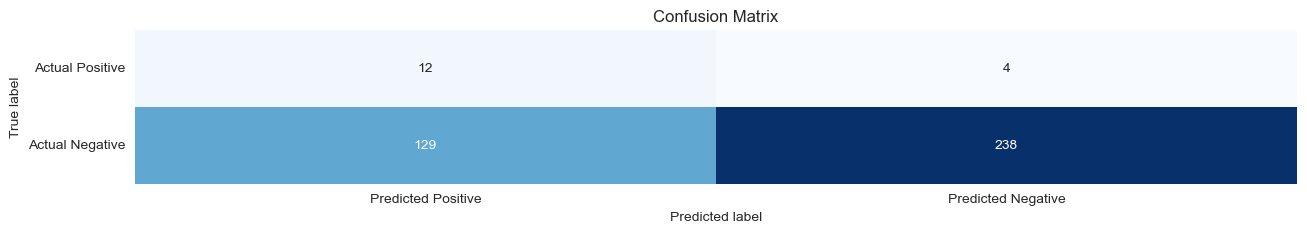

In [150]:
predictions_model= xgboost_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [151]:
train_report,validation_report =  classification_report_summary(xgboost_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.772727    0.862637  0.811321    0.817682      0.817682
recall       0.882075    0.740566  0.811321    0.811321      0.811321
f1-score     0.823789    0.796954  0.811321    0.810371      0.810371
support    212.000000  212.000000  0.811321  424.000000    424.000000

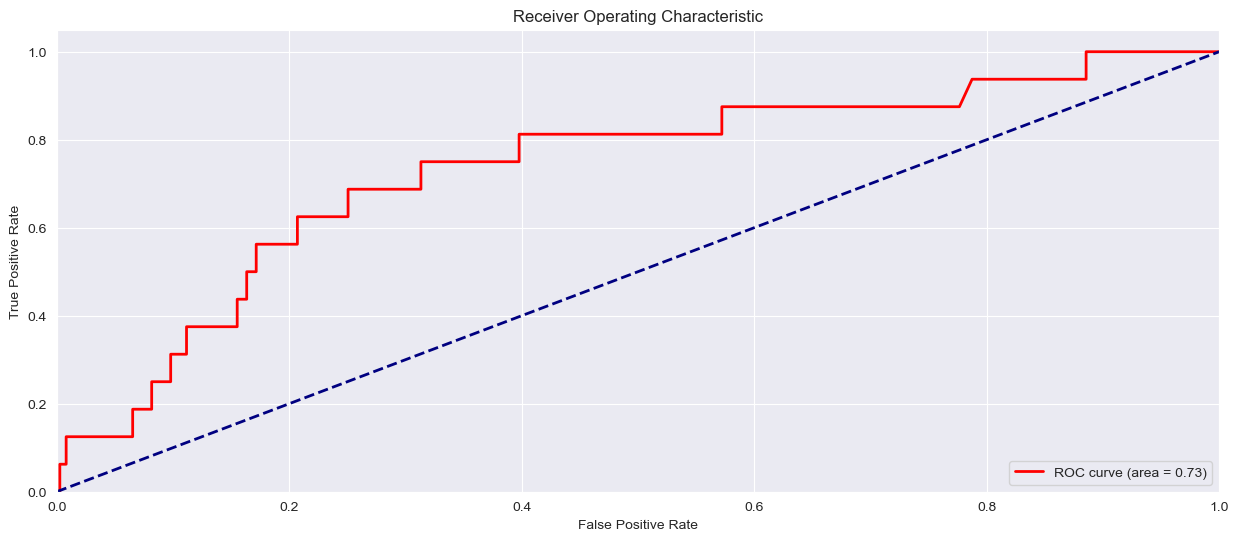

In [152]:
# Get the predicted probabilities
y_pred_proba = xgboost_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_xgboost_001_metrics = {
    'Model_Name': "xgboost_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

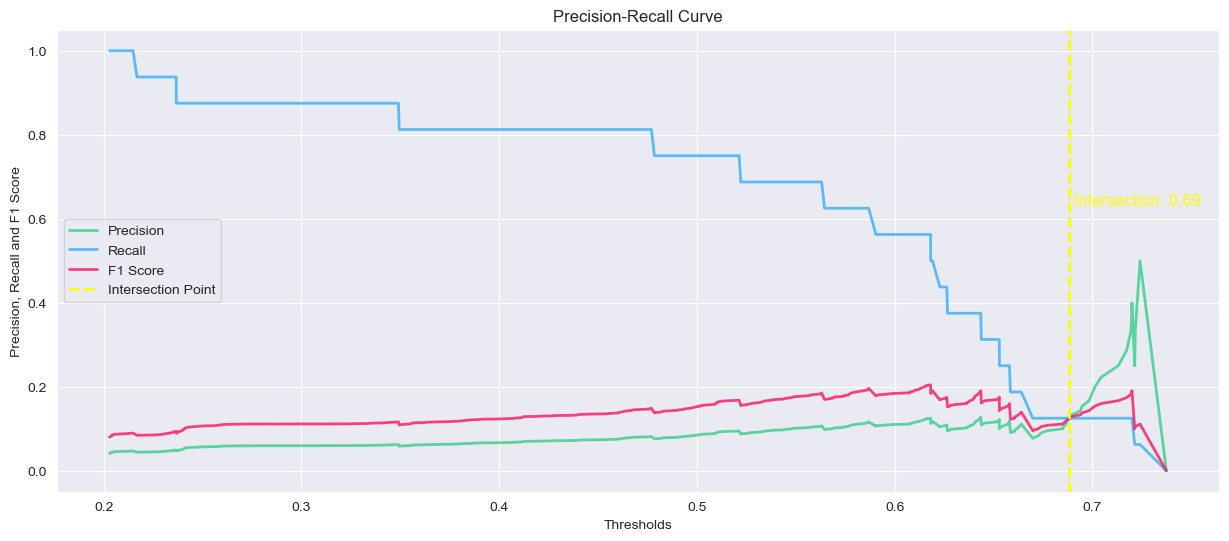

In [153]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [154]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row = pd.DataFrame({
    'Model_Name': "xgboost_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name': "model_xgboost_001_metrics"
}, index=range(1))

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name  \
0              baseline_model   
1                model_LR_001   
2               model_SVC_002   
3               model_KNN_001   
4      model_RandomForest_001   
5                     GNB_001   
6  model_GradientBoosting_001   
7      AdaBoostClassifier_001   
8                 xgboost_001   

                                    Model_parameters   roc_auc  Recall_train  \
0  LogisticRegression(class_weight='balanced', ra...  0.718495      0.820755   
1  solver=liblinear, penalty=l2, max_iter=100, C=...  0.729564      0.952830   
2          kernel=rbf, degree=1, C=1.438449888287663  0.719346      0.839623   
3  algorithm=ball_tree, metric=euclidean, n_neigh...  0.754343      0.806604   
4  criterion=gini, max_depth=25, max_features=sqr...  0.500000      0.000000   
5                                var_smoothing=1e-09  0.748808      0.867925   
6  learning_rate=0.001, max_depth=4, max_features...  0.750681      0.910377   
7                learning_rate=1e-05, n_estimators=2  0.651482      0.966981   
8  colsample_bytree=0.8, gamma=0.1, learning_rate...  0.733311      0.882075   

   Recall_validation  accuracy_train  accuracy_validation  f1_score_train  \
0             0.6875        0.740502             0.691906        0.235932   
1             0.8125        0.721698             0.490862        0.773946   
2             0.6875        0.790094             0.681462        0.800000   
3             0.7500        0.780660             0.618799        0.786207   
4             0.0000        0.500000             0.958225        0.000000   
5             0.8125        0.716981             0.566580        0.754098   
6             0.7500        0.801887             0.629243        0.821277   
7             0.8125        0.747642             0.503916        0.793037   
8             0.7500        0.811321             0.652742        0.823789   

   f1_score_validation                           metric_name  
0             0.157143                baseline_model_metrics  
1             0.117647                  model_LR_001_metrics  
2             0.152778                 model_SVC_002_metrics  
3             0.141176                 model_KNN_001_metrics  
4             0.000000        model_RandomForest_001_metrics  
5             0.135417                 model_GNB_001_metrics  
6             0.144578    model_GradientBoosting_001_metrics  
7             0.120370  model_AdaBoostClassifier_001_metrics  
8             0.152866             model_xgboost_001_metrics

# LightGBM Classifier

In [155]:
hyper_parameter_tuning = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}


In [156]:
lgb_model_001 =lgb.LGBMClassifier(random_state=42)

if re_run_model:
    GridSearch = GridSearchCV(lgb_model_001, param_grid=hyper_parameter_tuning, cv=5, n_jobs=-1, scoring='recall')
    GridSearch.fit(X_train, y_train)
    joblib.dump(GridSearch, 'model_saved_vr2/lgb_model_001.pkl')   
  
# Get the best model and evaluate on the test set
lgb_model_001_load = joblib.load('model_saved_vr2/lgb_model_001.pkl')
    
# Get the best model and evaluate on the test set
lgb_model_001 = lgb_model_001_load.best_estimator_
best_params = lgb_model_001_load.best_params_
best_score = lgb_model_001_load.best_score_
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 100,
 'n_estimators': 50,
 'num_leaves': 31,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.8}

C:\Users\hanns\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hanns\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


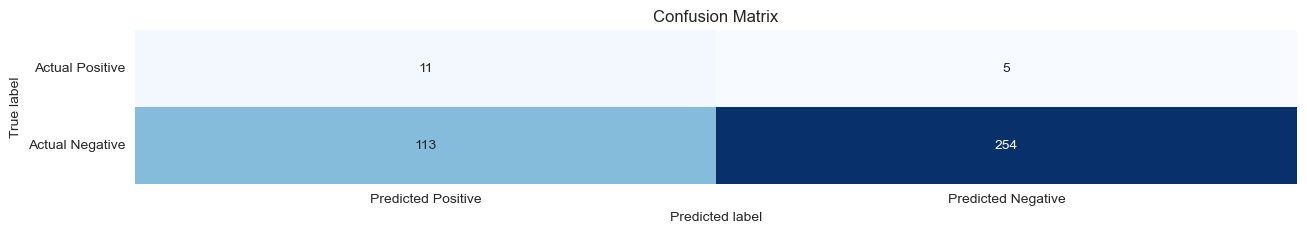

In [157]:
predictions_model= lgb_model_001.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [158]:
train_report,validation_report =  classification_report_summary(lgb_model_001, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.742616    0.807487  0.771226    0.775051      0.775051
recall       0.830189    0.712264  0.771226    0.771226      0.771226
f1-score     0.783964    0.756892  0.771226    0.770428      0.770428
support    212.000000  212.000000  0.771226  424.000000    424.000000

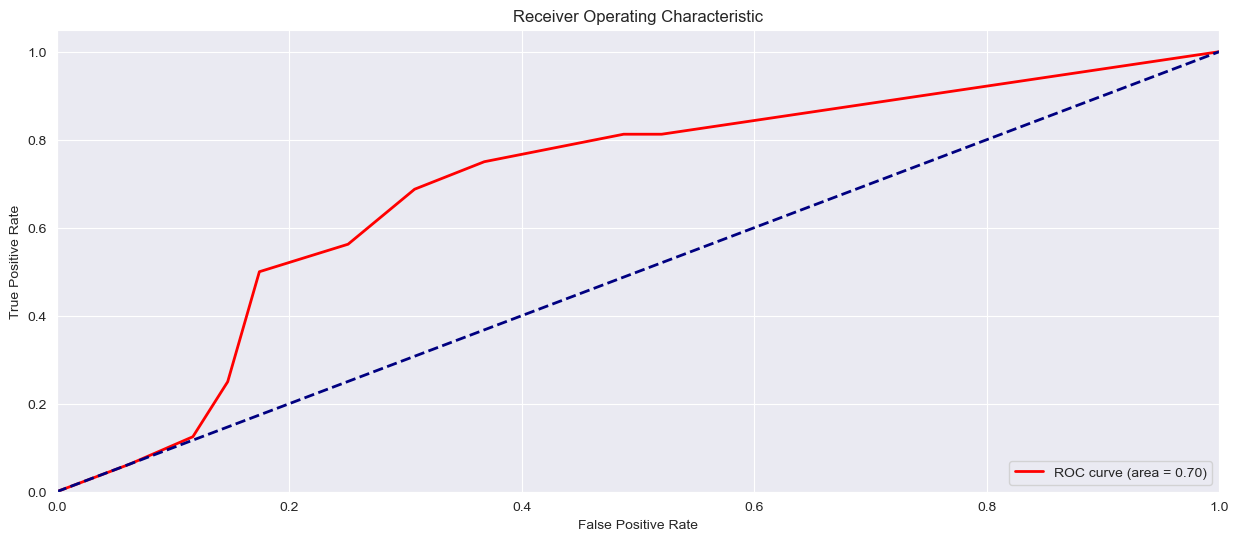

In [159]:
# Get the predicted probabilities
y_pred_proba = lgb_model_001.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

# table for a dataset, for comparing models
model_lgb_001_metrics = {
    'Model_Name': "lgb_model_001",
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
}

#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

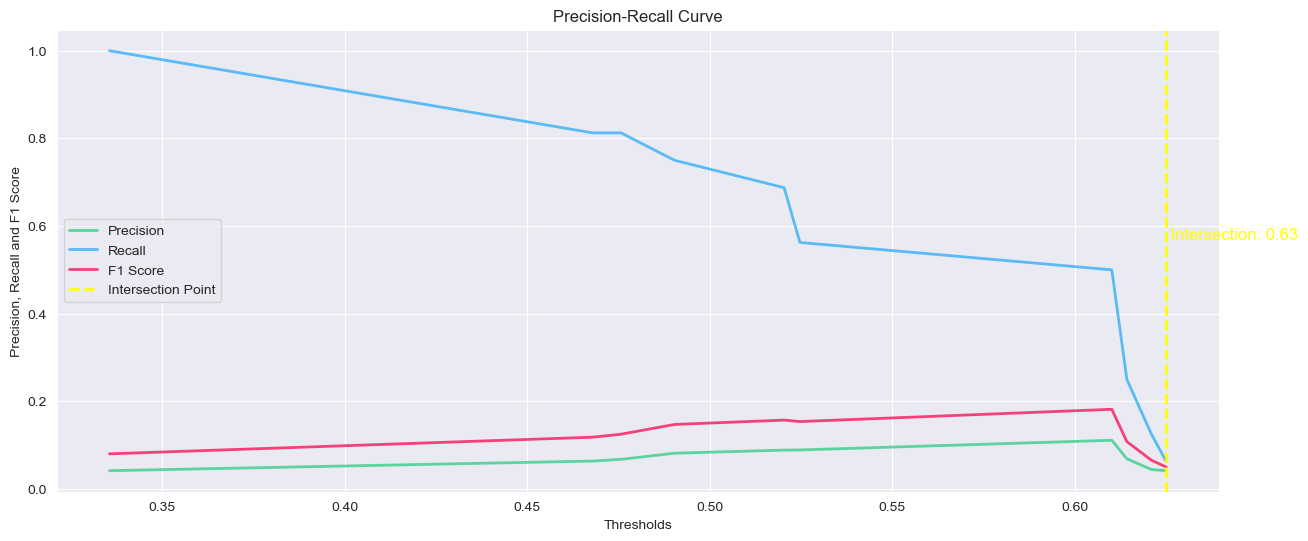

In [160]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [161]:
# convert the parameters to text
params_str = ", ".join([f"{key}={value}" for key, value in best_params.items()])
text = f"{params_str}"

new_row = pd.DataFrame({
    'Model_Name': "lgb_model_001",
    'Model_parameters': text,
    'roc_auc': roc_auc,
    'Recall_train': train_report["stroke"].loc["recall"],
    'Recall_validation':  validation_report["stroke"].loc["recall"],
    'accuracy_train' : train_report["accuracy"].loc["recall"],
    'accuracy_validation' : validation_report["accuracy"].loc["recall"],
    'f1_score_train' : train_report["stroke"].loc["f1-score"],
    'f1_score_validation' : validation_report["stroke"].loc["f1-score"],
    'metric_name': "model_lgb_001_metrics"
}, index=range(1))

results_models = pd.concat([results_models, new_row], ignore_index=True)
results_models

Model_Name  \
0              baseline_model   
1                model_LR_001   
2               model_SVC_002   
3               model_KNN_001   
4      model_RandomForest_001   
5                     GNB_001   
6  model_GradientBoosting_001   
7      AdaBoostClassifier_001   
8                 xgboost_001   
9               lgb_model_001   

                                    Model_parameters   roc_auc  Recall_train  \
0  LogisticRegression(class_weight='balanced', ra...  0.718495      0.820755   
1  solver=liblinear, penalty=l2, max_iter=100, C=...  0.729564      0.952830   
2          kernel=rbf, degree=1, C=1.438449888287663  0.719346      0.839623   
3  algorithm=ball_tree, metric=euclidean, n_neigh...  0.754343      0.806604   
4  criterion=gini, max_depth=25, max_features=sqr...  0.500000      0.000000   
5                                var_smoothing=1e-09  0.748808      0.867925   
6  learning_rate=0.001, max_depth=4, max_features...  0.750681      0.910377   
7                learning_rate=1e-05, n_estimators=2  0.651482      0.966981   
8  colsample_bytree=0.8, gamma=0.1, learning_rate...  0.733311      0.882075   
9  colsample_bytree=1.0, learning_rate=0.01, max_...  0.697122      0.830189   

   Recall_validation  accuracy_train  accuracy_validation  f1_score_train  \
0             0.6875        0.740502             0.691906        0.235932   
1             0.8125        0.721698             0.490862        0.773946   
2             0.6875        0.790094             0.681462        0.800000   
3             0.7500        0.780660             0.618799        0.786207   
4             0.0000        0.500000             0.958225        0.000000   
5             0.8125        0.716981             0.566580        0.754098   
6             0.7500        0.801887             0.629243        0.821277   
7             0.8125        0.747642             0.503916        0.793037   
8             0.7500        0.811321             0.652742        0.823789   
9             0.6875        0.771226             0.691906        0.783964   

   f1_score_validation                           metric_name  
0             0.157143                baseline_model_metrics  
1             0.117647                  model_LR_001_metrics  
2             0.152778                 model_SVC_002_metrics  
3             0.141176                 model_KNN_001_metrics  
4             0.000000        model_RandomForest_001_metrics  
5             0.135417                 model_GNB_001_metrics  
6             0.144578    model_GradientBoosting_001_metrics  
7             0.120370  model_AdaBoostClassifier_001_metrics  
8             0.152866             model_xgboost_001_metrics  
9             0.157143                 model_lgb_001_metrics

We see that this model does not outperform if we compared with the other ones.

# Conclusion modeling phase

Now we will plot the conclusions of all the models

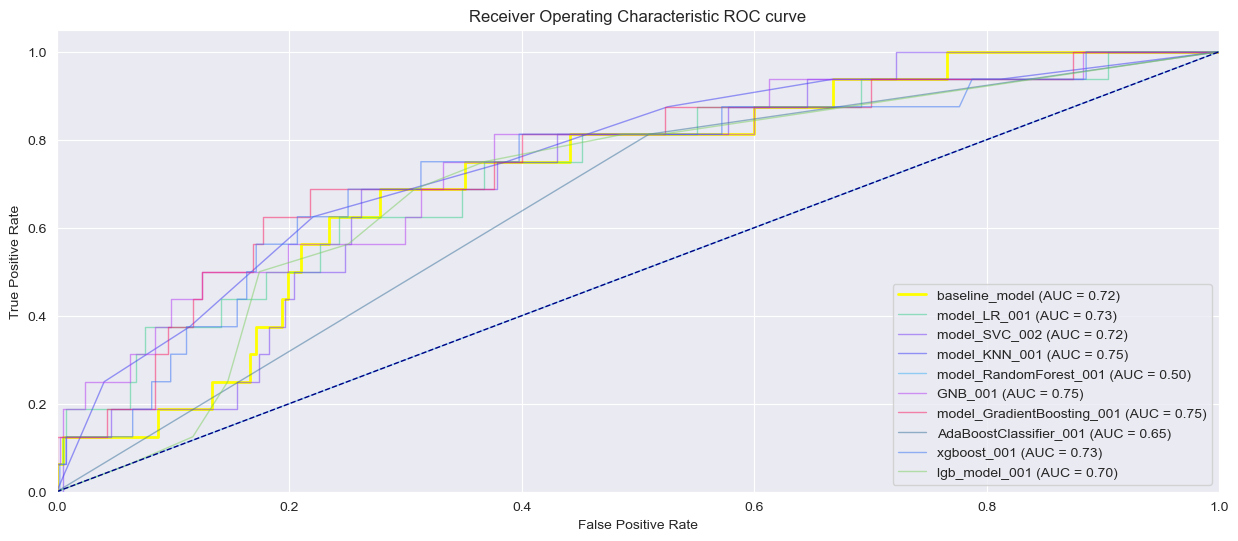

In [162]:
plt.figure(figsize=(15, 6))
# add each model departure
plt.plot(baseline_model_metrics["fpr"], baseline_model_metrics["tpr"], color="yellow", lw=2, label=f'{baseline_model_metrics["Model_Name"]} (AUC = {baseline_model_metrics["roc_auc"]:.2f})',  alpha=1)

# rest of the model
plt.plot(model_LR_001_metrics["fpr"], model_LR_001_metrics["tpr"], color=theme_color[0], lw=1, label=f'{model_LR_001_metrics["Model_Name"]} (AUC = {model_LR_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_SVC_002_metrics["fpr"], model_SVC_002_metrics["tpr"], color=theme_color[1], lw=1, label=f'{model_SVC_002_metrics["Model_Name"]} (AUC = {model_SVC_002_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_KNN_001_metrics["fpr"], model_KNN_001_metrics["tpr"], color=theme_color[2], lw=1, label=f'{model_KNN_001_metrics["Model_Name"]} (AUC = {model_KNN_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_RandomForest_001_metrics["fpr"], model_RandomForest_001_metrics["tpr"], color=theme_color[3], lw=1, label=f'{model_RandomForest_001_metrics["Model_Name"]} (AUC = {model_RandomForest_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_GNB_001_metrics["fpr"], model_GNB_001_metrics["tpr"], color=theme_color[4], lw=1, label=f'{model_GNB_001_metrics["Model_Name"]} (AUC = {model_GNB_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_GradientBoosting_001_metrics["fpr"], model_GradientBoosting_001_metrics["tpr"], color=theme_color[5], lw=1, label=f'{model_GradientBoosting_001_metrics["Model_Name"]} (AUC = {model_GradientBoosting_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_AdaBoostClassifier_001_metrics["fpr"], model_AdaBoostClassifier_001_metrics["tpr"], color=theme_color[6], lw=1, label=f'{model_AdaBoostClassifier_001_metrics["Model_Name"]} (AUC = {model_AdaBoostClassifier_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_xgboost_001_metrics["fpr"], model_xgboost_001_metrics["tpr"], color=theme_color[7], lw=1, label=f'{model_xgboost_001_metrics["Model_Name"]} (AUC = {model_xgboost_001_metrics["roc_auc"]:.2f})',  alpha=0.5)
plt.plot(model_lgb_001_metrics["fpr"], model_lgb_001_metrics["tpr"], color=theme_color[8], lw=1, label=f'{model_lgb_001_metrics["Model_Name"]} (AUC = {model_lgb_001_metrics["roc_auc"]:.2f})',  alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ROC curve')
plt.legend(loc="lower right")
plt.show()

- The models**_GradientBoosting_001** and **model_SVC_002** achieved the highest **AUC** metric, approximately 83%.
- However, when comparing the improvement in performance using **Recall** from the training to the validation set, **model_KNN_001** and **model_SVC_002** showed the best improvement.
- During the **validation phase**, **model_GNB_001** and **AdaBoostClassifier_001** exhibited a decrease in performance, but their overall performance was still adequate.
- Lastly, we encountered some errors with the Random Forest model. This could be due to various reasons, so we will set this model aside for now.

In [163]:
results_models["Recall_ratio"] = results_models["Recall_validation"] / results_models["Recall_train"]
results_models

Model_Name  \
0              baseline_model   
1                model_LR_001   
2               model_SVC_002   
3               model_KNN_001   
4      model_RandomForest_001   
5                     GNB_001   
6  model_GradientBoosting_001   
7      AdaBoostClassifier_001   
8                 xgboost_001   
9               lgb_model_001   

                                    Model_parameters   roc_auc  Recall_train  \
0  LogisticRegression(class_weight='balanced', ra...  0.718495      0.820755   
1  solver=liblinear, penalty=l2, max_iter=100, C=...  0.729564      0.952830   
2          kernel=rbf, degree=1, C=1.438449888287663  0.719346      0.839623   
3  algorithm=ball_tree, metric=euclidean, n_neigh...  0.754343      0.806604   
4  criterion=gini, max_depth=25, max_features=sqr...  0.500000      0.000000   
5                                var_smoothing=1e-09  0.748808      0.867925   
6  learning_rate=0.001, max_depth=4, max_features...  0.750681      0.910377   
7                learning_rate=1e-05, n_estimators=2  0.651482      0.966981   
8  colsample_bytree=0.8, gamma=0.1, learning_rate...  0.733311      0.882075   
9  colsample_bytree=1.0, learning_rate=0.01, max_...  0.697122      0.830189   

   Recall_validation  accuracy_train  accuracy_validation  f1_score_train  \
0             0.6875        0.740502             0.691906        0.235932   
1             0.8125        0.721698             0.490862        0.773946   
2             0.6875        0.790094             0.681462        0.800000   
3             0.7500        0.780660             0.618799        0.786207   
4             0.0000        0.500000             0.958225        0.000000   
5             0.8125        0.716981             0.566580        0.754098   
6             0.7500        0.801887             0.629243        0.821277   
7             0.8125        0.747642             0.503916        0.793037   
8             0.7500        0.811321             0.652742        0.823789   
9             0.6875        0.771226             0.691906        0.783964   

   f1_score_validation                           metric_name  Recall_ratio  
0             0.157143                baseline_model_metrics      0.837644  
1             0.117647                  model_LR_001_metrics      0.852723  
2             0.152778                 model_SVC_002_metrics      0.818820  
3             0.141176                 model_KNN_001_metrics      0.929825  
4             0.000000        model_RandomForest_001_metrics           NaN  
5             0.135417                 model_GNB_001_metrics      0.936141  
6             0.144578    model_GradientBoosting_001_metrics      0.823834  
7             0.120370  model_AdaBoostClassifier_001_metrics      0.840244  
8             0.152866             model_xgboost_001_metrics      0.850267  
9             0.157143                 model_lgb_001_metrics      0.828125

In [176]:
results_models.columns

Index(['Model_Name', 'Model_parameters', 'roc_auc', 'Recall_train',
       'Recall_validation', 'accuracy_train', 'accuracy_validation',
       'f1_score_train', 'f1_score_validation', 'metric_name', 'Recall_ratio',
       'size_exp'],
      dtype='object')

In [164]:
df_main_testing = predict_recall_test_values(model_LR_001, X_validation,y_validation,X_test,y_test, "baseline_model")
df_testing_0 = predict_recall_test_values(model_SVC_002, X_validation,y_validation,X_test,y_test, "model_LR_001")
df_testing_1 = predict_recall_test_values(model_SVC_002, X_validation,y_validation,X_test,y_test, "model_SVC_002")
df_testing_2 = predict_recall_test_values(model_KNN_001, X_validation,y_validation,X_test,y_test, "model_KNN_001")
df_testing_3 = predict_recall_test_values(model_RandomForest_001, X_validation,y_validation,X_test,y_test, "model_RandomForest_001")
df_testing_4 = predict_recall_test_values(GNB_001, X_validation,y_validation,X_test,y_test, "GNB_001")
df_testing_5 = predict_recall_test_values(model_GradientBoosting_001, X_validation,y_validation,X_test,y_test, "model_GradientBoosting_001")
df_testing_6 = predict_recall_test_values(AdaBoostClassifier_001, X_validation,y_validation,X_test,y_test, "AdaBoostClassifier_001")
df_testing_7 = predict_recall_test_values(xgboost_001, X_validation,y_validation,X_test,y_test, "xgboost_001")
df_testing_8 = predict_recall_test_values(lgb_model_001, X_validation,y_validation,X_test,y_test, "lgb_model_001")

df_main_testing = pd.concat([df_main_testing,df_testing_0, df_testing_1,df_testing_2, df_testing_3,df_testing_4,df_testing_5,df_testing_6,df_testing_7,df_testing_8], ignore_index=True)
df_main_testing

Model  Recall_Validation  Recall_Test
0              baseline_model             0.8125     1.000000
1                model_LR_001             0.6875     0.904762
2               model_SVC_002             0.6875     0.904762
3               model_KNN_001             0.7500     0.809524
4      model_RandomForest_001             0.0000     0.000000
5                     GNB_001             0.8125     1.000000
6  model_GradientBoosting_001             0.7500     1.000000
7      AdaBoostClassifier_001             0.8125     1.000000
8                 xgboost_001             0.7500     0.952381
9               lgb_model_001             0.6875     0.952381

After assessing the performance of various models, we could see that the **logistic regression** and  **GaussianNB**  the same behavior in the performance with in the recall.

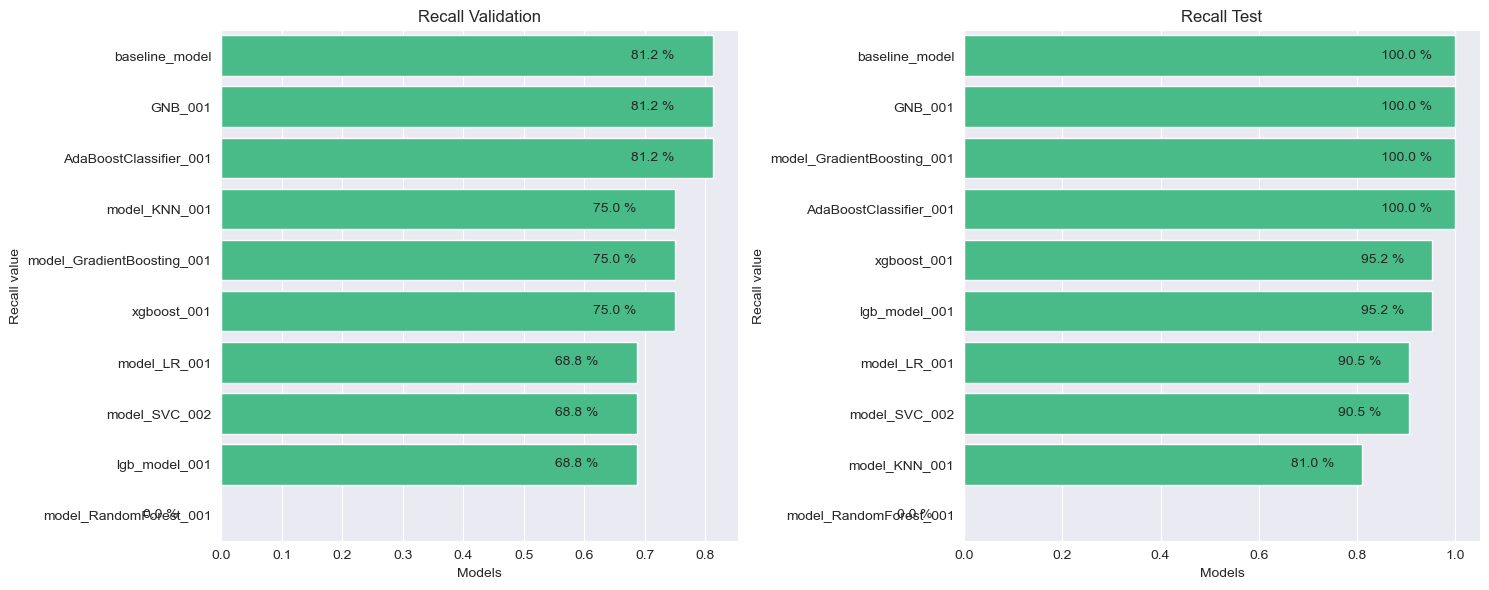

In [165]:
df_recall_v = df_main_testing.sort_values(by="Recall_Validation",ascending=False )
df_recall_t = df_main_testing.sort_values(by="Recall_Test",ascending=False )

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the Recall Validation
sns.barplot(data=df_recall_v, x='Recall_Validation', y='Model',  ax=axes[0])
axes[0].set_title('Recall Validation')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Recall value')

# Plotting the Recall Test
sns.barplot(data=df_recall_t, x='Recall_Test', y='Model', ax=axes[1])
axes[1].set_title('Recall Test')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Recall value')

# Plot the text
for i in [0,1]:
    for p in axes[i].patches:
        width = p.get_width()
        axes[i].text(width - 0.10, p.get_y() + p.get_height() / 2, f'{width*100:.1f} %', ha='center', va='center')


plt.tight_layout()
plt.show()

We had three models that performed the best: Logistic Regression, Gaussian Naive Bayes, and AdaBoost. These models demonstrated good performance when predicting values. 
We observed that the prediction accuracy of these three models is very low, in some cases falling below 50%, indicating poor performance.

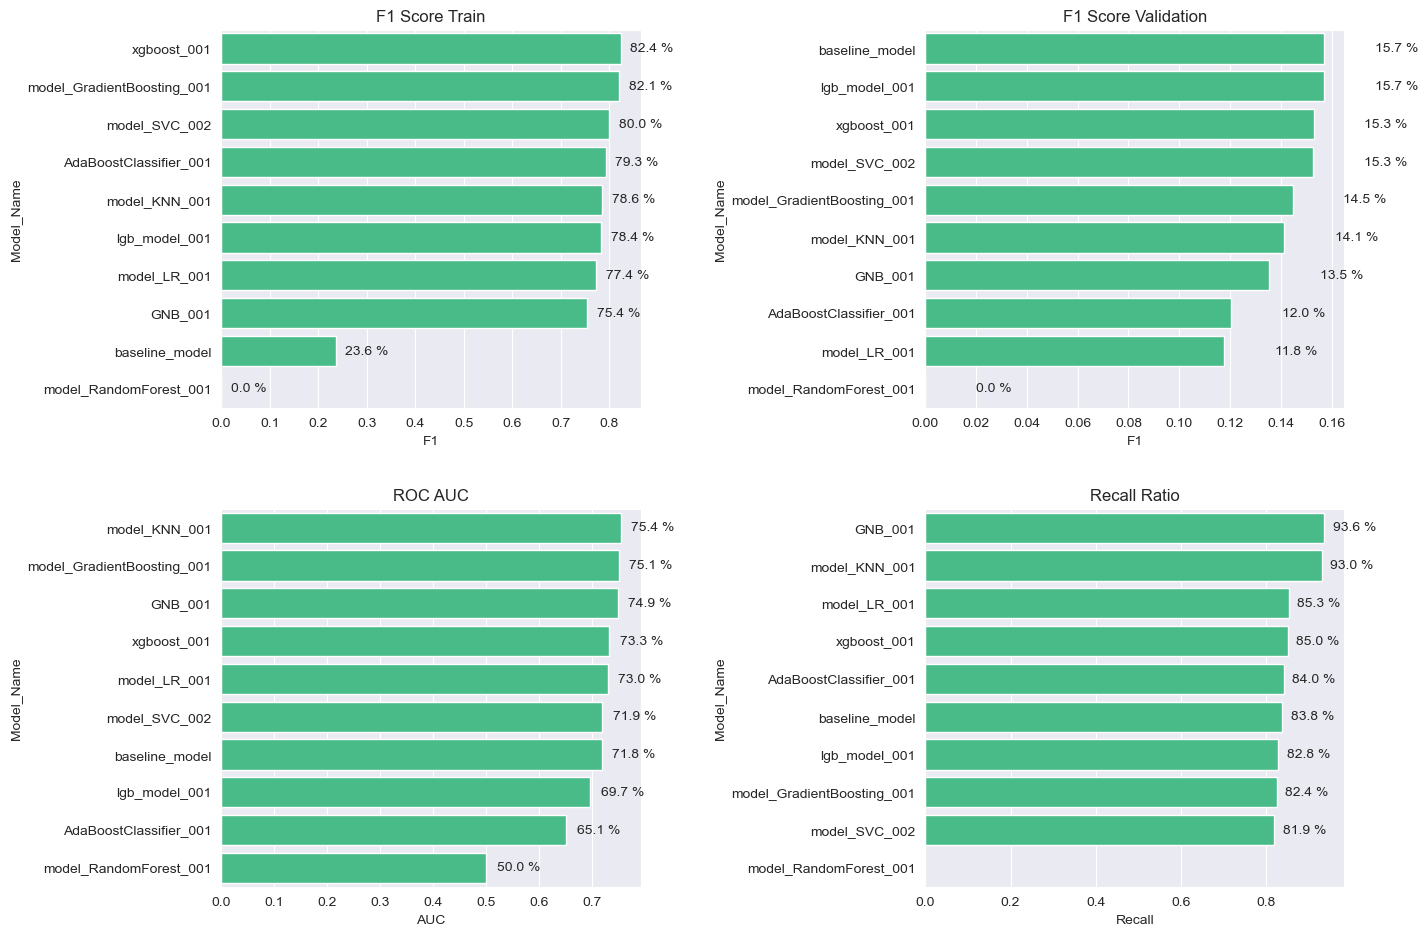

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Increased the height for more space

# Plotting f1_score_train sorted in descending order
sorted_data = results_models.sort_values(by='f1_score_train', ascending=False)
sns.barplot(data=sorted_data, x='f1_score_train', y='Model_Name', ax=axes[0,0])
axes[0,0].set_title('F1 Score Train')
axes[0,0].set_xlabel('F1')

# Plotting f1_score_validation sorted in descending order
sorted_data = results_models.sort_values(by='f1_score_validation', ascending=False)
sns.barplot(data=sorted_data, x='f1_score_validation', y='Model_Name', ax=axes[0,1])
axes[0,1].set_title('F1 Score Validation')
axes[0,1].set_xlabel('F1')

# Plotting roc_auc sorted in descending order
sorted_data = results_models.sort_values(by='roc_auc', ascending=False)
sns.barplot(data=sorted_data, x='roc_auc', y='Model_Name', ax=axes[1,0])
axes[1,0].set_title('ROC AUC')
axes[1,0].set_xlabel('AUC')

# Plotting Recall_ratio sorted in descending order
sorted_data = results_models.sort_values(by='Recall_ratio', ascending=False)
sns.barplot(data=sorted_data, x='Recall_ratio', y='Model_Name', ax=axes[1,1])
axes[1,1].set_title('Recall Ratio')
axes[1,1].set_xlabel('Recall')

# Plot the text
for i in range(2):
    for j in range(2):
        for p in axes[i, j].patches:
            width = p.get_width()
            axes[i, j].text(width + 0.02, p.get_y() + p.get_height() / 2, f'{width*100:.1f} %', ha='left', va='center')

plt.tight_layout(pad=3.0)  # Increased padding for more space between plots
plt.show()

In [167]:
import plotly.express as px
results_models['size_exp'] = results_models['roc_auc']** 50
fig = px.scatter(results_models, 
                 x='Recall_ratio', 
                 y='f1_score_validation', 
                 size='size_exp', 
                 color='Model_Name', 
                 hover_name='Model_Name',
                 title='Scatter Plot of Recall, ROC AUC, and F1 Score Validation',
                 labels={'Recall_ratio': 'Recall Ratio', 'roc_auc': 'ROC AUC'},
                 size_max=50)  # Adjust size_max for better visibility

# Show plot
fig.show()

After analysing all this charts, we will be going with KNN and GNB model that are the one that got the best performance, and we will try to apply a voting model where depending on the quality we will be choosing one or the other.

# Ensemble model ratios

In [168]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [190]:
# Define the base models
model1 = GaussianNB(var_smoothing=1e-09)
model2 = KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=7, weights='distance') 

# Create the ensemble model using voting
ensemble_model = VotingClassifier(estimators=[('GNB', model1), ('knn', model2)], voting='soft')

# Train the ensemble model
ensemble_model = ensemble_model.fit(X_train, y_train)

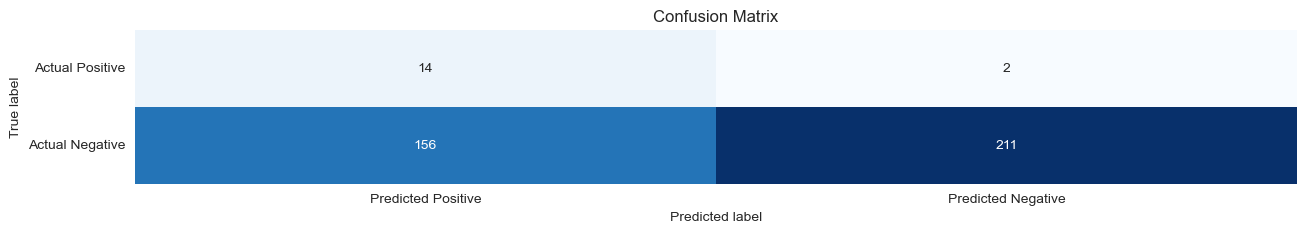

In [170]:
predictions_model= ensemble_model.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [171]:
train_report,validation_report =  classification_report_summary(ensemble_model, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    1.000000    0.995305  0.997642    0.997653      0.997653
recall       0.995283    1.000000  0.997642    0.997642      0.997642
f1-score     0.997636    0.997647  0.997642    0.997641      0.997641
support    212.000000  212.000000  0.997642  424.000000    424.000000

In [172]:
validation_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision   0.082353    0.990610  0.587467    0.536482      0.952667
recall      0.875000    0.574932  0.587467    0.724966      0.587467
f1-score    0.150538    0.727586  0.587467    0.439062      0.703480
support    16.000000  367.000000  0.587467  383.000000    383.000000

0.756982288828338


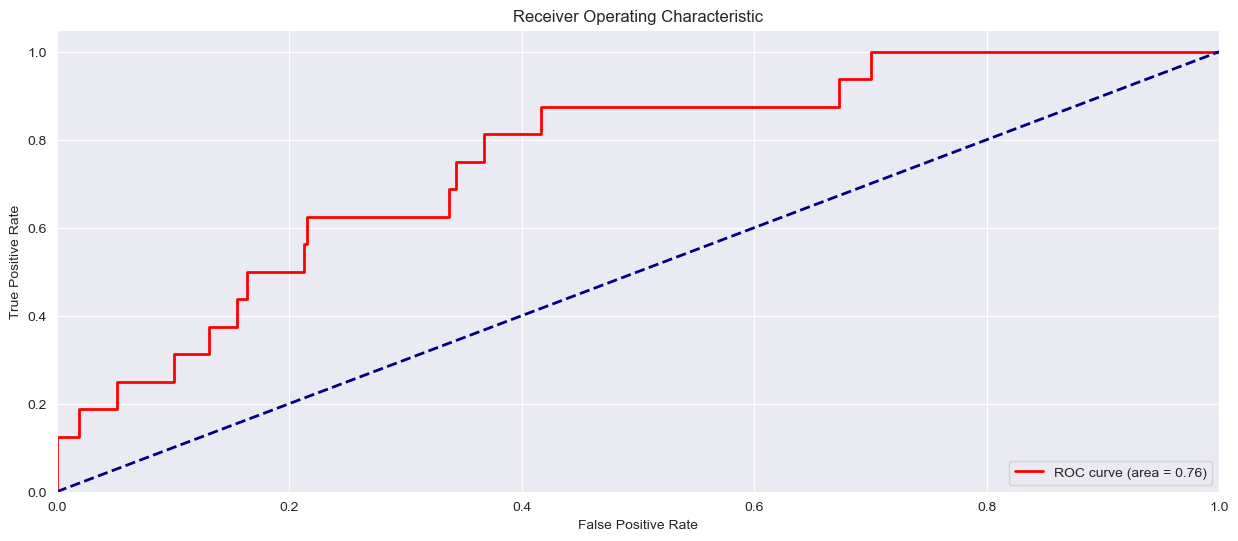

In [191]:
# Get the predicted probabilities
y_pred_proba = ensemble_model.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(roc_auc)
#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

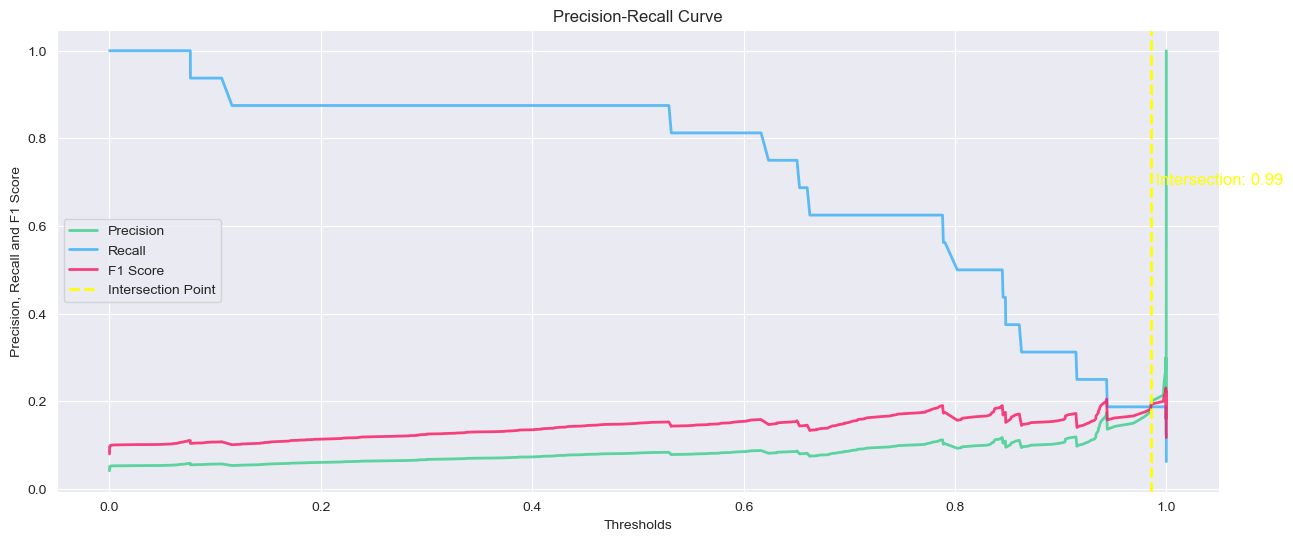

In [174]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [175]:
joblib.dump(ensemble_model, 'model_saved_vr2/ensemble_model_001.pkl')

['model_saved_vr2/ensemble_model_001.pkl']

# Ensemble model performance models
Now we will be choosing the best models that we will be choosing


In [178]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [180]:
gnb = GaussianNB(var_smoothing=1e-09)
adaboost = AdaBoostClassifier(learning_rate=1e-05, n_estimators=2)
logreg = LogisticRegression(solver='liblinear', penalty='l2', max_iter=100, C=0.0006951927961775605)

In [192]:
# Create the ensemble model using voting
ensemble_model = VotingClassifier(estimators=[('GNB', gnb), ('adaboost', adaboost), ('logreg', logreg)], voting='soft')

# Train the ensemble model
ensemble_model = ensemble_model.fit(X_train, y_train)

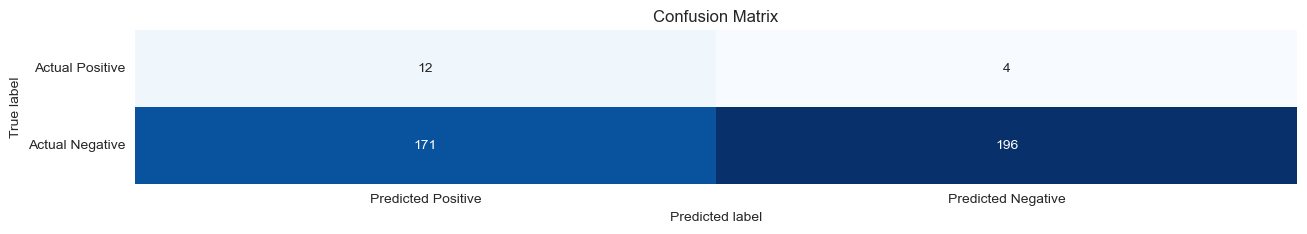

In [183]:
predictions_model= ensemble_model.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions_model, labels= [1,0])
conf_heatmap(conf_matrix)

In [184]:
train_report,validation_report =  classification_report_summary(ensemble_model, X_train, y_train,X_validation,y_validation)
train_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision    0.673684    0.856115  0.733491    0.764900      0.764900
recall       0.905660    0.561321  0.733491    0.733491      0.733491
f1-score     0.772636    0.678063  0.733491    0.725349      0.725349
support    212.000000  212.000000  0.733491  424.000000    424.000000

In [185]:
validation_report

stroke   no stroke  accuracy   macro avg  weighted avg
precision   0.065574    0.980000  0.543081    0.522787      0.941799
recall      0.750000    0.534060  0.543081    0.642030      0.543081
f1-score    0.120603    0.691358  0.543081    0.405981      0.667514
support    16.000000  367.000000  0.543081  383.000000    383.000000

0.7440395095367848


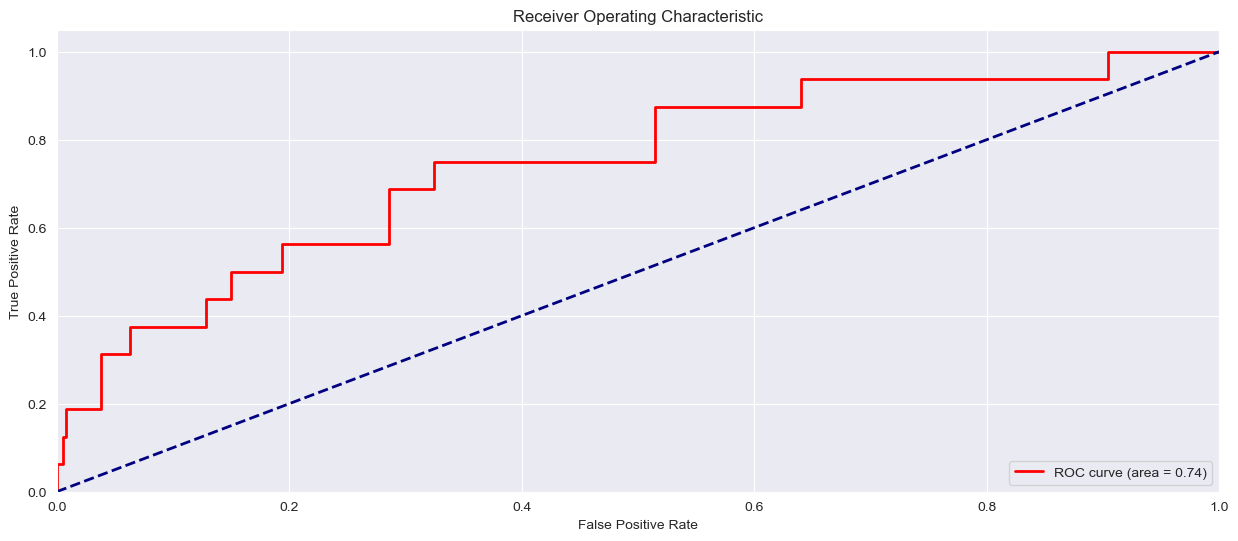

In [193]:
# Get the predicted probabilities
y_pred_proba = ensemble_model.predict_proba(X_validation)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(roc_auc)
#  Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

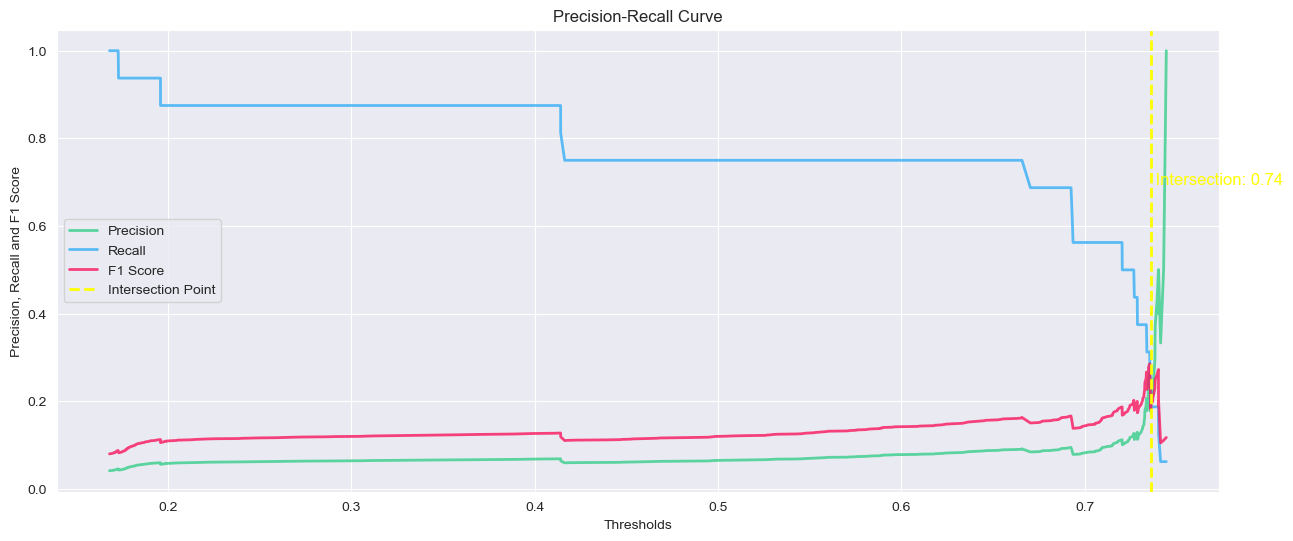

In [187]:
thresholds_recall_curve(y_pred_proba, y_validation) 

In [188]:
joblib.dump(ensemble_model, 'model_saved_vr2/ensemble_model_002.pkl')

['model_saved_vr2/ensemble_model_002.pkl']